### 1. Загрузка данныx

In [1]:
#!pip install optuna-integration[sklearn] for  kaggle

#!pip install yellowbrick

In [2]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import  pickle
import gc

from tqdm import tqdm
import time

import phik

# Блок  импортов и настроек Optuna
import optuna
from optuna.integration import OptunaSearchCV 
from optuna import distributions
import logging
import warnings

optuna.logging.set_verbosity(optuna.logging.WARNING) # отключить вывод optunaSearchCV 
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning) # предупреждения optuna.exceptions off.


from sklearn.metrics import (f1_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             root_mean_squared_error,
                             r2_score,
                             mean_absolute_error
)
from sklearn.preprocessing import(
                                   StandardScaler,
                                   MinMaxScaler,
                                   OneHotEncoder,
                                   LabelEncoder,
                                   OrdinalEncoder              
)



import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import re

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC                    

from category_encoders import HashingEncoder, TargetEncoder

from yellowbrick.target import ClassBalance

RANDOM_STATE = 51










###  Вспомогательные  функции

In [3]:
def full_display (data,  lenth=5):
    with pd.option_context('display.max_columns', None): 
        display(data.head(lenth))

def missing(data):
    missing = pd.DataFrame(data.isna().sum(),columns=["missing_values"]).reset_index().query('missing_values != 0 ')
    missing.rename(columns={'index': 'column_name'}, inplace=True)
    return missing.reset_index(drop=True)
    

def plot_hist (data,  bins=20):
    # data.plot(kind= 'hist' , bins=20, edgecolor='black')
    data.hist(bins=bins)
    plt.grid(True)
    plt.show()

def plot_bar(data):
    data.round(3).value_counts().plot(kind='bar',edgecolor='black')
    plt.grid(True)
    plt.show()


def plot_features (value,feature):
    df= pd.DataFrame({
    'feature': feature,
    'value': value
     }).sort_values(by='value', ascending=False)

    plt.figure(figsize=(12, 8))
    # sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)
    sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)

    plt.title('График важности признаков.', fontsize=16, pad=20)
    plt.xlabel('Значение признака.', fontsize=10)
    plt.ylabel('Признак.', fontsize=10)
    plt.grid(True)

    plt.show()

def score( y_true,y_pred):
    print('accuracy: ',accuracy_score( y_true, y_pred))
    print('precision: ', precision_score( y_true, y_pred))
    print( 'recall: ', recall_score( y_true, y_pred))
    print('f1: ',f1_score(y_true, y_pred))          




def plot_hist_prob(column,data,bins=100):
    plt.figure(figsize=(8, 5))

    sns.histplot(data, x=column, hue='churn', bins=bins, alpha=0.5, stat="probability",common_norm=False)

    plt.xlabel('Value')
    plt.ylabel('probability')
    plt.title(f"Распределение столбца {column}")
    plt.grid(True)
    plt.show()


def score_reg( y_true,y_pred):
    print('RMSE: ',root_mean_squared_error(y_true, y_pred))
    print('MAE: ', mean_absolute_error( y_true, y_pred))
    print( 'R2: ', r2_score( y_true, y_pred))
   

In [4]:
try:
    path_data_train= Path(Path.cwd()/'adengi-internship_1/train.csv')
    path_data_test= Path(Path.cwd()/'adengi-internship_1/test.csv')
   
    df_train = pd.read_csv(path_data_train)
    df_test = pd.read_csv(path_data_test)
    
    
except:

    path_data_train = Path('/kaggle/input/a-money/train.csv')
    path_data_test = Path('/kaggle/input/a-money/test.csv')

    df_train = pd.read_csv(path_data_train)
    df_test = pd.read_csv(path_data_test)
    
print(path_data_train, '\n',path_data_test)


C:\Users\dmitr\project_loc\A_money\adengi-internship_1\train.csv 
 C:\Users\dmitr\project_loc\A_money\adengi-internship_1\test.csv


In [5]:
with pd.option_context('display.max_columns', None): 
    display(df_train.head(3))
    

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,days_finish_loan,ag,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,issues,principal,interest,overdue_interest,overdue_fee,nbki_score,payment_frequency,status,loan_id,client_id,source,first_source,interface,type,repayment_type,client_type,settlement,client_type.1,region,gender,loan_order,have_extension,contact_cases,created_at,closed_at,start_dt,churn
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-0.389028,-1.053530,-0.629296,-0.61762,-0.340659,-0.539615,-0.619312,NaN,NaN,NaN,-0.063933,-0.143015,-0.434972,0.347703,-0.347703,-0.502878,-0.218265,-0.185707,1.837622,2,1,464867,111035,11,0,0,2,3,1,г Москва,repeated,г Москва,male,2,0,NaN,2022-12-23 17:50:25,2022-12-31 16:09:23,NaN,0
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.294731,-0.436189,-0.020140,-0.61762,-1.145865,-0.539615,1.354330,NaN,NaN,NaN,-0.063933,-0.143015,-0.434972,0.347703,-0.347703,-0.502878,-0.218265,-0.185707,2.262600,2,1,4569010,604426,11,0,2,1,0,1,г Москва,repeated,г Москва,female,14,0,NaN,2024-06-29 22:26:08,2024-07-27 16:21:49,NaN,0
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-1.113590,-0.259806,0.153905,-0.61762,-0.685747,-0.502706,1.354330,NaN,NaN,NaN,-0.063933,-0.143015,-0.429509,0.347703,-0.347703,-0.484111,-0.218265,-0.185707,2.262600,2,1,985489,334703,11,4,2,2,3,1,г Пермь,repeated,край Пермский,male,10,0,NaN,2023-04-10 21:06:38,2023-05-10 07:51:18,NaN,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   monthly_income         float64
 1   work_experience        float64
 2   requested_sum          float64
 3   main_agreement_amount  float64
 4   main_agreement_term    float64
 5   requested_period_days  float64
 6   requested_amount       float64
 7   req_app_amount         float64
 8   approved_amount        float64
 9   period_days            float64
 10  days_finish_loan       float64
 11  ag                     float64
 12  cnt_ext                float64
 13  term                   float64
 14  price                  float64
 15  elecs_sum              float64
 16  recurents_sum          float64
 17  tamount                float64
 18  issues                 float64
 19  principal              float64
 20  interest               float64
 21  overdue_interest       float64
 22  overdue_fee       

In [7]:
missing_train = missing(df_train)
missing_train

,column_name,missing_values
0,monthly_income,207
1,work_experience,2648360
2,requested_sum,3546390
3,requested_period_days,441618
4,requested_amount,414836
5,req_app_amount,414836
6,cnt_ext,3582556
7,term,3582556
8,price,3582816
9,elecs_sum,5794


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 43 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   monthly_income         1348680 non-null  float64
 1   work_experience        463225 non-null   float64
 2   requested_sum          163790 non-null   float64
 3   main_agreement_amount  1348743 non-null  float64
 4   main_agreement_term    1348743 non-null  float64
 5   requested_period_days  1200882 non-null  float64
 6   requested_amount       1209772 non-null  float64
 7   req_app_amount         1209772 non-null  float64
 8   approved_amount        1348743 non-null  float64
 9   period_days            1348743 non-null  float64
 10  days_finish_loan       1348743 non-null  float64
 11  ag                     1348743 non-null  float64
 12  cnt_ext                151701 non-null   float64
 13  term                   151701 non-null   float64
 14  price             

In [9]:
missing_test = missing(df_test)
missing_test

,column_name,missing_values
0,monthly_income,63
1,work_experience,885518
2,requested_sum,1184953
3,requested_period_days,147861
4,requested_amount,138971
5,req_app_amount,138971
6,cnt_ext,1197042
7,term,1197042
8,price,1197133
9,elecs_sum,1984


In [10]:
print('TRUE- списки столбцов с пропусками в train и test полностью совпадают : ', end='')
print(all(missing_test['column_name'] == missing_train['column_name']))

TRUE- списки столбцов с пропусками в train и test полностью совпадают : True


## 2. Предобработка

In [11]:
# ключи- признаки , значение - обработка
prepocessing ={}

### 2.1 Признаки 'object'

In [12]:
# Список столбцов 'object'
df_train.select_dtypes(include='object').columns

Index(['settlement', 'client_type.1', 'region', 'gender', 'created_at',
       'closed_at', 'start_dt'],
      dtype='object')

In [13]:
list_object=list(df_train.select_dtypes(include='object').columns)

In [14]:
print('Пропуски  в train (object): ')
display(missing(df_train.select_dtypes(include='object')))
print('Пропуски  в test (object): ')
missing(df_test.select_dtypes(include='object'))

Пропуски  в train (object): 


,column_name,missing_values
0,start_dt,3581930


Пропуски  в test (object): 


,column_name,missing_values
0,start_dt,1197668


In [15]:
df_train.select_dtypes(include='object').sample(7)

,settlement,client_type.1,region,gender,created_at,closed_at,start_dt
1859941,г Ревда,repeated,обл Свердловская,female,2023-01-05 03:54:37,2023-01-10 14:53:50,NaN
1303170,село Загайново,repeated,край Алтайский,male,2023-04-11 03:47:43,2023-05-10 16:47:21,NaN
2228854,пгт Онохой,new,Респ Бурятия,female,2024-09-24 09:23:48,2024-10-15 16:44:19,NaN
2189423,г Магнитогорск,repeated,обл Челябинская,male,2024-06-01 21:04:37,2024-06-26 05:05:25,NaN
3218500,г Омск,repeated,обл Омская,male,2023-01-05 15:28:46,2023-01-13 18:53:14,NaN
1594553,г Москва,new,г Москва,female,2023-05-27 17:24:30,2023-06-06 12:01:08,NaN
27734,село Надеждино,repeated,Респ Башкортостан,male,2023-12-26 09:32:09,2024-01-28 07:03:18,NaN


#### 2.1.1 column 'region'

In [16]:
region= df_train['region'].unique()
print("Количество элементов в столбце 'region ': " ,len(region))

Количество элементов в столбце 'region ':  189


In [17]:
region

array(['г Москва', 'край Пермский', 'обл Самарская', 'Респ Удмуртская',
       'обл Калининградская', 'обл Ленинградская', 'обл Челябинская',
       'обл Московская', 'край Ставропольский',
       'АО Ханты-Мансийский Автономный округ - Югра', 'Респ Башкортостан',
       'обл Ульяновская', 'край Красноярский', 'г Санкт-Петербург',
       'Респ Татарстан', 'обл Новосибирская', 'обл Ивановская',
       'г Москва Москва', 'обл Омская', 'Респ Бурятия', 'обл Брянская',
       'обл Тульская', 'обл Владимирская', 'обл Псковская',
       'обл Волгоградская', 'обл Тверская',
       'обл Кемеровская область - Кузбасс', 'обл Иркутская',
       'край Камчатский', 'край Краснодарский', 'обл Ростовская',
       'Респ Хакасия', 'АО Чукотский', 'обл Свердловская',
       'Респ Калмыкия', 'обл Саратовская', 'край Забайкальский',
       'обл Кировская', 'край Алтайский', 'Респ Карелия',
       'обл Магаданская', 'обл Архангельская', 'АО Ямало-Ненецкий',
       'край Хабаровский', 'Респ Дагестан', 'обл Н

In [18]:
replace_dict = {
    'чуваш': 'Чувашская',
    'мари': 'Марий Эл',
     'луган': 'ЛНР',
    'донец': 'ДНР',
    'якут': 'Якутия',
    'осет':'Северная Осетия',
    'саха' : 'Якутия'
    
}


replace_dict_2  = {
    'ямал':  'ао Ямало-Ненецкий',
    'ненец': 'ао Ненецкий',
    'ханты' : 'ао Ханты-Мансийский',
     
    'чукотск':'ао Чукотский', 
    'еврейск': 'аобл Еврейская'
    
}

replace_dict_3 = {
    'москв':'обл Московская',
    'севаст':'респ Крым',
    ' санкт':'обл Ленинградская'
}
def change(text):
    text =' '.join(text)
    string= False
    for i in replace_dict:
        if  re.search( rf'(?i)\w*{i}\w*', text):
            string = replace_dict.get(i)
    if  string:
        return 'респ '+string
    return 'респ ' + text   

def  change_2(text): 
    for i in replace_dict_2:
        if re.search( rf'(?i)\w*{i}\w*', text):
            return replace_dict_2.get(i) 

def  change_3(text): 
    for i in replace_dict_3:
        if re.search( rf'(?i)\w*{i}\w*', text):
            return replace_dict_3.get(i) 
      

def region_1(string):
    # string = string.astype('str')
    if re.search(r'(?i)\bобл\b|\bобласть\b', string):
        # print('обл')
        return 'обл '+set(re.findall(r'\b\w*кая\b', string)).pop().capitalize()
    #elif re.search(r'\bг\b|\bрайон\b', string):
        # print('г')
        #return 'г '+ set(re.sub(r'(?i)\bг\b|\bрайон\b' ,'', string).split()).pop()
    elif re.search(r'\bг\b|\bрайон\b', string):
        #print('г')
        return change_3(string)
    
    elif  re.search(r'(?i)респ', string):
        # print('респ')
        resp = list(set(re.sub(r'(?i)\b\w*респ\w*\b', '', string).split()))
        return change(resp) 
    elif re.search(r'(?i)край',string) and not re.search(r'(?i)область', string):
        return 'край '+set(re.findall(r'\b\w*ский\b', string)).pop().capitalize()

    elif re.search(r'(?i)\bао\b|\bавтономный\b|\bеврейская\b', string):
        # print('AO',string, 'sss')
        return change_2(string)
    return 'unknown ' + string

In [19]:
%%time
df_train['region_new']= df_train['region'].map(region_1)
df_test['region_new'] = df_test['region'].map(region_1)

CPU times: total: 1min 25s
Wall time: 1min 26s


In [20]:
# %%time
# df_train['region_new']= df_train['region'].apply(region_1)
# df_test['region_new'] = df_test['region'].apply(region_1)

In [21]:
region_train= df_train['region_new'].unique()
region_test = df_test['region_new'].unique()
print(f'Число регионов в test: {len(region_test)},', f'Число регионов в train: {len(region_train)}')

print('дельта test^train: ',set(df_test['region_new'])^set( df_train['region_new']))

Число регионов в test: 86, Число регионов в train: 86
дельта test^train:  set()


In [22]:
prepocessing['region_new']='one_hot'

Результат предобработки:
- удалены неявные дубликаты,  количество регионов -86.
- кодировка для регрессионных моделей 'one_hot',  деревянных - 'ordinal' (label)

#### 2.1.2 column 'settlement'

In [23]:
print('settlement unique(): ', len(df_train['settlement'].unique()))

N=7000 #  частота <10000 закодируем other
settlement= Counter(df_train['settlement'])
vocab_settelement = [i[0] for i in settlement.most_common(N)] 

def settlement_columns(data):
    #data['settlement_new'] =data['settlement'].apply(lambda x: x.lower() if x in vocab_settelement else 'others')   
    data['settlement_new'] =data['settlement'].where(data['settlement'].isin(vocab_settelement),'others')

settlement unique():  47425


In [24]:
%%time
settlement_columns(df_train)
settlement_columns(df_test)

prepocessing['settlement_new']='one_hot'

CPU times: total: 1.08 s
Wall time: 1.11 s


#### 2.1.3 columns 'created_at', 'closed_at', 'start_dt'

##### 2.1.3.1 попытка восстановить ['closed_at'] (возможно улучшим модель)

Воспользуемся  следеющим  алгоритмом(предварительно):
- создадим  df_train['period'] = (df_train['closed_at']-df_train['created_at']).dt.days
- обучим модель,  используя LGBMRegressor,  предсказывать df_train['period'].
- Заменим df_train['period']. период на предсказанные значения,  создадим  в test['period']

- продублируем 'start_dt_new' = 'start_dt (безлайн сделан  с другим алгоритмом заполнения)
- заполним пропуски в 'start_dt_new'  значениями 'closed_at'  в предположении что пропуски - наблюдения без  пролонгаций
- добавим  признак ['prolong'] = .apply( lambda x:  0  if pd.isna(x.start_dt) else max(1,(x.closed_at-x.start_dt_dubl).days), axis=1)
- переобучим модель  используя новые признаки(  включая start_dt_new )
- реализация  в пункте 9.
  


___________________________

In [25]:
def time_columns (data):
    data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce')
    data['start_dt'] = pd.to_datetime(data['start_dt'], errors='coerce')
    
    data['start_dt_new'] = data['start_dt'].copy()  # для  реализации п. 2.1.3.1 в baseline не используется
     
    data['start_dt'] = data.groupby('client_id')['start_dt'].transform(
            lambda x: x.fillna(x.min()))
    
    data['start_dt'] = data['start_dt'].fillna(data['created_at'])

    data['month'] = data['created_at'].dt.month
    data['day'] = data['created_at'].dt.day
    data['week'] = data['created_at'].dt.dayofweek

    reference_date = pd.to_datetime('2022-01-01')
    
    data['start_dt_xg'] = data['start_dt_new'].fillna(data['created_at'])
    data['start_dt_xg'] =(data['start_dt_xg']-reference_date).dt.days
    

    data['created_at'] = (data['created_at'] - reference_date).dt.days
    data['start_dt'] = (data['start_dt'] - reference_date).dt.days
    
    
    data['days_diff'] = data['start_dt']-data['created_at']
    data['days_diff_1'] = data['start_dt_xg']-data['created_at']
    
    

In [26]:
%%time
time_columns(df_train)
time_columns(df_test)

CPU times: total: 11min 6s
Wall time: 11min 20s


In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 54 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   monthly_income         float64       
 1   work_experience        float64       
 2   requested_sum          float64       
 3   main_agreement_amount  float64       
 4   main_agreement_term    float64       
 5   requested_period_days  float64       
 6   requested_amount       float64       
 7   req_app_amount         float64       
 8   approved_amount        float64       
 9   period_days            float64       
 10  days_finish_loan       float64       
 11  ag                     float64       
 12  cnt_ext                float64       
 13  term                   float64       
 14  price                  float64       
 15  elecs_sum              float64       
 16  recurents_sum          float64       
 17  tamount                float64       
 18  issues                

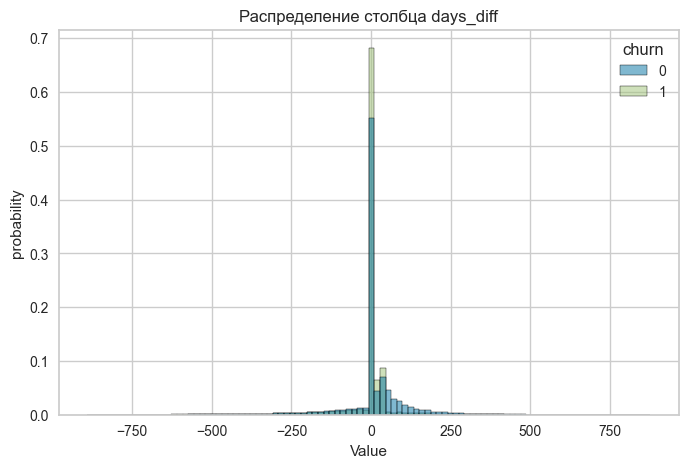

In [28]:
plot_hist_prob ('days_diff',df_train)

In [29]:
prepocessing.update({
    'created_at':'scale',
    ' start_dt':'scale',
    'days_diff':'scale',
    'start_dt_xg':'scale'
})

prepocessing

{'region_new': 'one_hot',
 'settlement_new': 'one_hot',
 'created_at': 'scale',
 ' start_dt': 'scale',
 'days_diff': 'scale',
 'start_dt_xg': 'scale'}

In [30]:
# prepocessing.update({'period':'scale','prolong':'scale', 'created_at':'scale', 'closed_at':'scale', 'start_dt':'scale'})

#### 2.1.4  'gender', 'client_type.1'

In [31]:
df_train['client_type.1'].unique(), df_test['client_type.1'].unique()

(array(['repeated', 'new'], dtype=object),
 array(['repeated', 'new'], dtype=object))

In [32]:
df_train['gender'].unique(), df_test['gender'].unique()

(array(['male', 'female'], dtype=object),
 array(['male', 'female'], dtype=object))

In [33]:
prepocessing.update({'client_type.1':'one_hot','gender':'one_hot'})
prepocessing

{'region_new': 'one_hot',
 'settlement_new': 'one_hot',
 'created_at': 'scale',
 ' start_dt': 'scale',
 'days_diff': 'scale',
 'start_dt_xg': 'scale',
 'client_type.1': 'one_hot',
 'gender': 'one_hot'}

_____________________

### 2.2 Признаки 'float'

In [34]:
df_train.select_dtypes(include='float').columns

Index(['monthly_income', 'work_experience', 'requested_sum',
       'main_agreement_amount', 'main_agreement_term', 'requested_period_days',
       'requested_amount', 'req_app_amount', 'approved_amount', 'period_days',
       'days_finish_loan', 'ag', 'cnt_ext', 'term', 'price', 'elecs_sum',
       'recurents_sum', 'tamount', 'issues', 'principal', 'interest',
       'overdue_interest', 'overdue_fee', 'nbki_score', 'contact_cases'],
      dtype='object')

In [35]:
full_display(df_train.select_dtypes(include='float').describe(),lenth=8)
# df_train.select_dtypes(include='float').describe()

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,days_finish_loan,ag,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,issues,principal,interest,overdue_interest,overdue_fee,nbki_score,contact_cases
count,4.036000e+06,1.387847e+06,489817.000000,4.036207e+06,4.036207e+06,3.594589e+06,3.621371e+06,3.621371e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,453651.000000,453651.000000,453391.000000,4.030413e+06,4.030413e+06,4.034433e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,3.951731e+06,225917.000000
mean,-8.252097e-05,1.327124e-04,-0.000607,-1.432715e-04,1.383222e-04,3.266345e-04,-2.585087e-04,-3.261837e-04,7.910522e-05,1.383222e-04,1.464083e-04,7.153011e-05,0.000419,0.000688,0.001338,3.622507e-05,-1.118859e-05,1.909305e-04,1.431514e-05,-1.431514e-05,2.708158e-04,3.633334e-04,2.109503e-04,3.273367e-04,1.506301
std,9.431023e-01,9.999002e-01,0.997373,1.000089e+00,1.000341e+00,1.001271e+00,9.997052e-01,9.999505e-01,1.000235e+00,1.000341e+00,1.000475e+00,9.998904e-01,1.000511,1.000548,1.001336,1.001141e+00,1.000608e+00,1.003192e+00,9.978587e-01,9.978587e-01,1.002095e+00,1.001687e+00,9.992414e-01,1.000063e+00,1.430518
min,-7.560081e-04,-2.522225e+00,-0.592014,-9.858535e-01,-1.145865e+00,-1.657011e+00,-1.318104e+00,-5.241477e+00,-1.152100e+00,-1.145865e+00,-5.396155e-01,-1.761946e+00,-0.720608,-1.149255,-0.908121,-6.393252e-02,-1.430153e-01,-9.813316e-01,-2.530519e+02,-1.105251e+00,-5.028780e-01,-2.182650e-01,-1.857070e-01,-1.766011e+00,1.000000
25%,-7.505928e-04,-7.846654e-01,-0.462179,-6.870721e-01,-3.406587e-01,-3.890285e-01,-8.330511e-01,-6.292957e-01,-7.512400e-01,-3.406587e-01,-4.104309e-01,-8.270634e-01,-0.720608,-0.561187,-0.647906,-6.393252e-02,-1.430153e-01,-5.762984e-01,-4.098445e-01,-6.002189e-01,-4.778550e-01,-2.182650e-01,-1.857070e-01,-8.119808e-01,1.000000
50%,-7.488827e-04,8.411442e-02,-0.267427,-3.209154e-01,1.769741e-01,4.261034e-01,-8.342339e-02,-1.071620e-01,-2.167598e-01,1.769741e-01,-2.443364e-01,-9.993219e-02,-0.720608,-0.561187,-0.343282,-6.393252e-02,-1.430153e-01,-2.610464e-01,2.845741e-01,-2.845741e-01,-3.152056e-01,-2.182650e-01,-1.857070e-01,-1.788514e-01,1.000000
75%,-7.448212e-04,9.528942e-01,0.057159,5.080537e-01,1.769741e-01,4.261034e-01,1.195353e+00,6.760386e-01,5.181504e-01,1.769741e-01,-4.422167e-03,6.271990e-01,0.698299,0.256993,0.260883,-6.393252e-02,-1.430153e-01,2.935129e-01,6.002189e-01,4.098445e-01,5.763692e-02,-2.182650e-01,-1.857070e-01,7.448237e-01,1.000000
max,1.339736e+03,9.528942e-01,5.899720,1.141358e+01,8.804188e+00,1.401163e+01,7.412853e+00,5.636309e+00,9.938363e+00,8.804188e+00,1.651275e+01,4.470607e+00,3.536112,3.274034,10.166475,9.001068e+01,6.804536e+01,2.821236e+02,1.105251e+00,2.530519e+02,6.156176e+01,1.460302e+02,4.719982e+01,2.535799e+00,64.000000


In [36]:
full_display(df_test.select_dtypes(include='float').describe(),lenth=8)

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,days_finish_loan,ag,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,issues,principal,interest,overdue_interest,overdue_fee,nbki_score,contact_cases
count,1.348680e+06,463225.000000,163790.000000,1.348743e+06,1.348743e+06,1.200882e+06,1.209772e+06,1.209772e+06,1.348743e+06,1.348743e+06,1.348743e+06,1.348743e+06,151701.000000,151701.000000,151610.000000,1.346759e+06,1.346759e+06,1.348125e+06,1.348743e+06,1.348743e+06,1.348743e+06,1.348743e+06,1.348743e+06,1.320766e+06,75952.000000
mean,2.469486e-04,-0.000398,0.001816,4.287500e-04,-4.139389e-04,-9.777119e-04,7.738284e-04,9.764088e-04,-2.367279e-04,-4.139389e-04,-4.381369e-04,-2.140588e-04,-0.001254,-0.002058,-0.004001,-1.084099e-04,3.348383e-05,-5.713835e-04,-4.283904e-05,4.283904e-05,-8.104351e-04,-1.087300e-03,-6.312834e-04,-9.793911e-04,1.509401
std,1.153626e+00,1.000301,1.007819,9.997354e-01,9.989805e-01,9.961864e-01,1.000882e+00,1.000148e+00,9.992968e-01,9.989805e-01,9.985772e-01,1.000329e+00,0.998475,0.998362,0.995988,9.965769e-01,9.981792e-01,9.903851e-01,1.006382e+00,1.006382e+00,9.937051e-01,9.949332e-01,1.002267e+00,9.998116e-01,1.407463
min,-7.560081e-04,-2.522225,-0.592014,-9.858535e-01,-1.145865e+00,-1.657011e+00,-1.318104e+00,-4.371254e+00,-1.152100e+00,-1.145865e+00,-5.396155e-01,-1.658071e+00,-0.720608,-1.149255,-0.908380,-6.393252e-02,-1.430153e-01,-9.813261e-01,-2.136362e+02,-1.105251e+00,-5.028780e-01,-4.119530e-01,-7.230584e-01,-1.766011e+00,1.000000
25%,-7.505928e-04,-0.784665,-0.462179,-6.870721e-01,-3.406587e-01,-3.890285e-01,-8.330511e-01,-6.292957e-01,-7.512400e-01,-3.406587e-01,-4.104309e-01,-8.270634e-01,-0.720608,-0.561187,-0.652207,-6.393252e-02,-1.430153e-01,-5.736731e-01,-4.098445e-01,-6.002189e-01,-4.778550e-01,-2.182650e-01,-1.857070e-01,-8.119808e-01,1.000000
50%,-7.488827e-04,0.084114,-0.267427,-3.209154e-01,1.769741e-01,4.261034e-01,-8.342339e-02,-1.071620e-01,-2.167598e-01,1.769741e-01,-2.443364e-01,-9.993219e-02,-0.720608,-0.561187,-0.349213,-6.393252e-02,-1.430153e-01,-2.595385e-01,2.845741e-01,-2.845741e-01,-3.152056e-01,-2.182650e-01,-1.857070e-01,-1.831879e-01,1.000000
75%,-7.447499e-04,0.952894,0.057159,5.080537e-01,1.769741e-01,4.261034e-01,1.195353e+00,6.760386e-01,5.181504e-01,1.769741e-01,-4.422167e-03,6.271990e-01,0.698299,0.256993,0.256646,-6.393252e-02,-1.430153e-01,2.935129e-01,6.002189e-01,4.098445e-01,5.763692e-02,-2.182650e-01,-1.857070e-01,7.404872e-01,2.000000
max,1.339736e+03,0.952894,5.899720,1.141358e+01,8.804188e+00,1.401163e+01,7.412853e+00,5.636309e+00,9.938363e+00,8.804188e+00,1.629129e+01,4.470607e+00,4.955018,5.575166,9.886915,6.476057e+01,5.144399e+01,1.553928e+02,1.105251e+00,2.136362e+02,2.784022e+01,7.365204e+01,1.477848e+02,2.535799e+00,42.000000


In [37]:
# missing_values_x	- train, missing_values_y - test
pd.merge(missing(df_train.select_dtypes(include='float')),missing(df_test.select_dtypes(include='float')), on='column_name',how='outer')

,column_name,missing_values_x,missing_values_y
0,cnt_ext,3582556,1197042
1,contact_cases,3810290,1272791
2,elecs_sum,5794,1984
3,monthly_income,207,63
4,nbki_score,84476,27977
5,price,3582816,1197133
6,recurents_sum,5794,1984
7,req_app_amount,414836,138971
8,requested_amount,414836,138971
9,requested_period_days,441618,147861


- monthly_income - среднемесячный заработок клиента (зарплата)
- work_experience - кол-во лет стажа клиента
- requested_sum - запрашиваемая сумма клиента для займа, если interface - alfa
- requested_period_days - запрашиваемый срок по займу
- requested_amount - запрашиваемая сумма клиента по займу
- req_app_amount - разница между запрашиваемой суммой займа и одобренной
- cnt_ext - кол-во пролонгаций по займу
- term - срок пролонгации (список)
- price - цена пролонгации (список)
- elecs_sum - штрафы, пени
- recurents_sum - штрафы, пени (там вроде как различия в этапах их начисления)
- tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
- nbki_score - скор клиента от рисков
- contact_cases - кол-во обращений клиента с коллекшн

#### 2.2.1  column  'monthly_income' среднемесячный заработок клиента (зарплата)

In [38]:
def df_describe (name):
    display(df_train[[name]].describe().join(df_test[[name]].describe(),
                                            lsuffix='_train', rsuffix='_test'))

In [39]:
df_describe('monthly_income')

,monthly_income_train,monthly_income_test
count,4.036000e+06,1.348680e+06
mean,-8.252097e-05,2.469486e-04
std,9.431023e-01,1.153626e+00
min,-7.560081e-04,-7.560081e-04
25%,-7.505928e-04,-7.505928e-04
50%,-7.488827e-04,-7.488827e-04
75%,-7.448212e-04,-7.447499e-04
max,1.339736e+03,1.339736e+03


In [40]:
display(df_train.loc[df_train['monthly_income']>10,'monthly_income'], 
df_test.loc[df_test['monthly_income']>10,'monthly_income'])

3988621    1339.735927
3988622    1339.735927
Name: monthly_income, dtype: float64

1343394    1339.735899
Name: monthly_income, dtype: float64

Выбросы обработаем:  разделим  'monthly_income' в строках: 3988621, 3988622, 1343394  на 10**3

In [41]:
df_test.loc[df_test['monthly_income']>10,'monthly_income'] =\
    df_test.loc[df_test['monthly_income']>10,'monthly_income']/1000

df_train.loc[df_train['monthly_income']>10,'monthly_income'] =\
    df_train.loc[df_train['monthly_income']>10,'monthly_income']/1000

Предварительно: количество пропусков незначительное признак  вероятно стандартизирован , пропуски (заполним медианным значением) 

In [42]:
def simpl_median(name):
    imp_median = SimpleImputer(strategy='median')
    df_train[name] = imp_median.fit_transform(df_train[[name]]) 
    df_test[name] = imp_median.transform(df_test[[name]])

In [43]:
simpl_median('monthly_income')

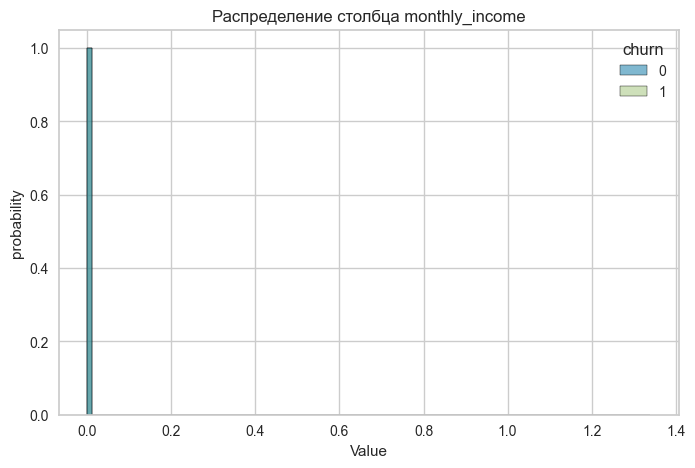

In [44]:
plot_hist_prob('monthly_income', df_train, bins=100)

In [45]:
# проверка
display(missing(df_train[['monthly_income']]), missing(df_test[['monthly_income']]))

,column_name,missing_values


,column_name,missing_values


#### 2.2.2 column 'cnt_ext'  кол-во пролонгаций по займу

In [46]:
df_train['cnt_ext'].value_counts()

cnt_ext
-0.720608    251325
-0.011155     82043
 2.117205     57692
 0.698299     39541
 1.407752     23046
 2.826659         3
 3.536112         1
Name: count, dtype: int64

In [47]:
df_test['cnt_ext'].value_counts()

cnt_ext
-0.720608    84089
-0.011155    27336
 2.117205    19161
 0.698299    13512
 1.407752     7602
 4.955018        1
Name: count, dtype: int64

In [48]:
print(np.sort(df_train['cnt_ext'].unique()), '\n', np.sort( df_test['cnt_ext'].unique()))

[-0.72060812 -0.01115479  0.69829853  1.40775186  2.11720518  2.8266585
  3.53611183         nan] 
 [-0.72060812 -0.01115479  0.69829853  1.40775186  2.11720518  4.95501848
         nan]


Предварительно:  признак  вероятно стандартизирован, пропуски - loan без пролонгации, заполним минимальным значением( соответствует 0 )

In [49]:
def min_simple(name):
    df_train[name]=df_train[name].fillna(df_train[name].min())
    df_test[name]=df_test[name].fillna(df_test[name].min())

In [50]:
df_train['cnt_ext'].min(), df_test['cnt_ext'].min()

(-0.7206081182984045, -0.7206081182984045)

In [51]:
min_simple('cnt_ext')

# Проверка
print(np.sort(df_train['cnt_ext'].unique()), '\n', np.sort( df_test['cnt_ext'].unique()))

[-0.72060812 -0.01115479  0.69829853  1.40775186  2.11720518  2.8266585
  3.53611183] 
 [-0.72060812 -0.01115479  0.69829853  1.40775186  2.11720518  4.95501848]


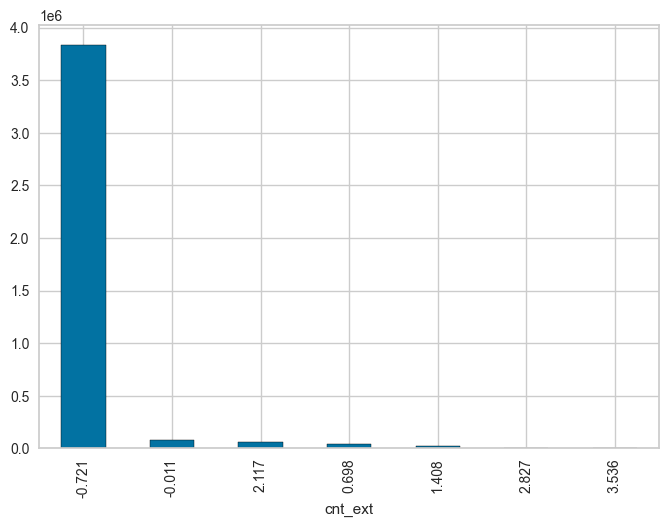

In [52]:
plot_bar(df_train['cnt_ext'])

### 2.2.3 column 'contact_cases' кол-во обращений клиента с коллекшн

In [53]:
np.sort(df_train['contact_cases'].unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 38., 39., 42.,
       44., 64., nan])

In [54]:
np.sort(df_test['contact_cases'].unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 30., 31., 32., 33., 36., 39., 42., nan])

Предварительно:  пропуски заполним нолями, нужно масштабирование.(дискретный, количественный признак)

In [55]:
def zerro_simple(name):
    df_train[name]=df_train[name].fillna(0)
    df_test[name]=df_test[name].fillna(0)

In [56]:
zerro_simple('contact_cases')

In [57]:
display(missing(df_train[['contact_cases']]),missing(df_test[['contact_cases']]))

,column_name,missing_values


,column_name,missing_values


In [58]:
prepocessing['contact_cases']='scale'
prepocessing

{'region_new': 'one_hot',
 'settlement_new': 'one_hot',
 'created_at': 'scale',
 ' start_dt': 'scale',
 'days_diff': 'scale',
 'start_dt_xg': 'scale',
 'client_type.1': 'one_hot',
 'gender': 'one_hot',
 'contact_cases': 'scale'}

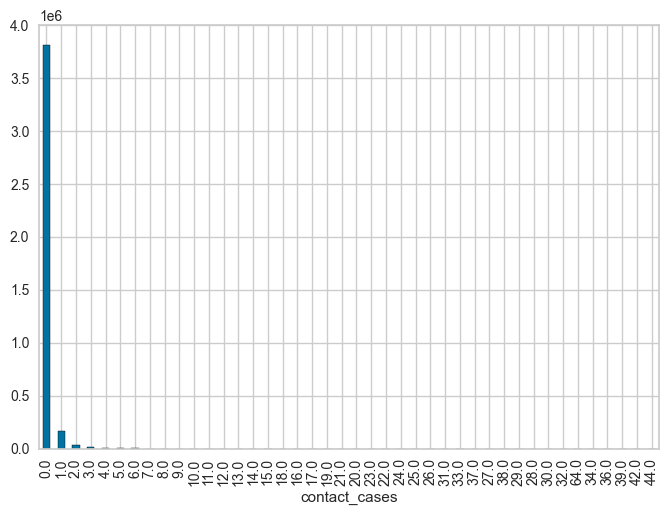

In [59]:
plot_bar(df_train['contact_cases'])

#### 2.2.4  'elecs_sum' - штрафы, пени
#### recurents_sum - штрафы, пени (там вроде как различия в этапах их начисления)

In [60]:
df_describe('elecs_sum')

,elecs_sum_train,elecs_sum_test
count,4.030413e+06,1.346759e+06
mean,3.622507e-05,-1.084099e-04
std,1.001141e+00,9.965769e-01
min,-6.393252e-02,-6.393252e-02
25%,-6.393252e-02,-6.393252e-02
50%,-6.393252e-02,-6.393252e-02
75%,-6.393252e-02,-6.393252e-02
max,9.001068e+01,6.476057e+01


In [61]:
df_describe('recurents_sum')

,recurents_sum_train,recurents_sum_test
count,4.030413e+06,1.346759e+06
mean,-1.118859e-05,3.348383e-05
std,1.000608e+00,9.981792e-01
min,-1.430153e-01,-1.430153e-01
25%,-1.430153e-01,-1.430153e-01
50%,-1.430153e-01,-1.430153e-01
75%,-1.430153e-01,-1.430153e-01
max,6.804536e+01,5.144399e+01


In [62]:
len(df_train['elecs_sum'].unique()),len(df_test['elecs_sum'].unique())

(8101, 3528)

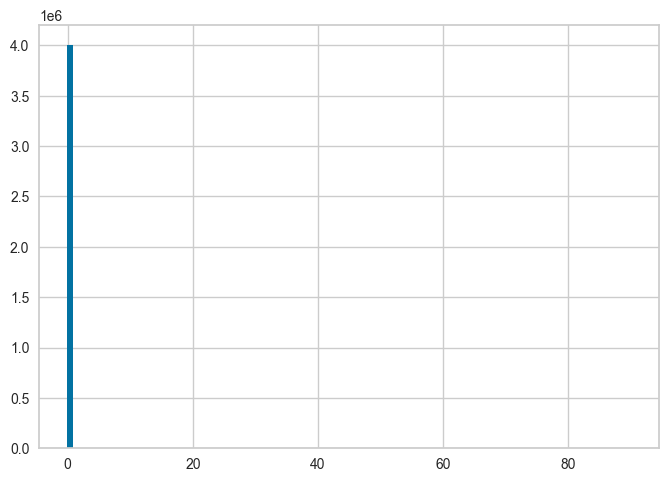

In [63]:
plot_hist(df_train['elecs_sum'],bins=100)

In [64]:
len(df_train['recurents_sum'].unique()),len(df_test['recurents_sum'].unique())

(22778, 9640)

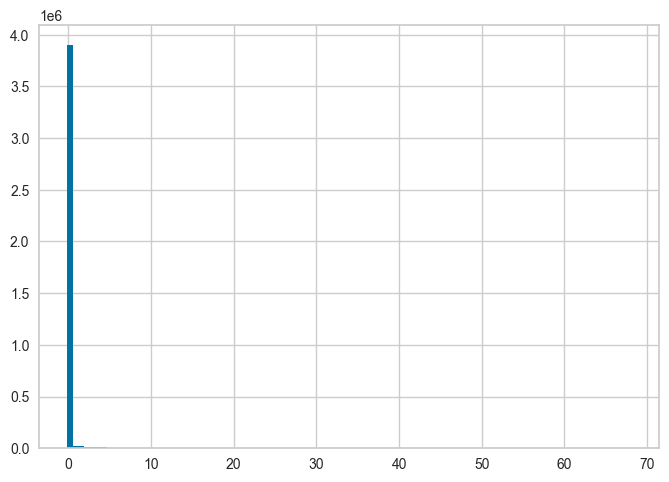

In [65]:
plot_hist(df_train['recurents_sum'],bins=100)

In [66]:
df_train[['elecs_sum','recurents_sum']].corr()

,elecs_sum,recurents_sum
elecs_sum,1.000000,-0.001417
recurents_sum,-0.001417,1.000000


Предварительно :корреляция очень слабая(оставим оба признака)  незначительное количество  пропусков  заполним  минимальным значением( предположительно эквивалент  нуля),  вероятно использована стандартная  нормализация.

In [67]:
min_simple('elecs_sum')
min_simple('recurents_sum')

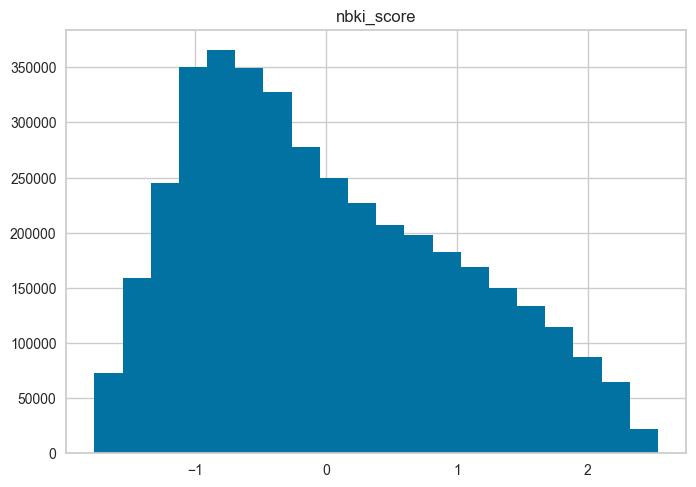

In [68]:
plot_hist(df_train[['nbki_score']])

Предварительно :заполним пропуски  медианным значением.,  прдположительно  стандартно нормализован.

In [69]:
simpl_median('nbki_score')

In [70]:
display(missing(df_train[['nbki_score']]),missing(df_test[['nbki_score']]))

,column_name,missing_values


,column_name,missing_values


#### 2.2.6 'price' - цена пролонгации (список)

In [71]:
df_describe('price')

,price_train,price_test
count,453391.000000,151610.000000
mean,0.001338,-0.004001
std,1.001336,0.995988
min,-0.908121,-0.908380
25%,-0.647906,-0.652207
50%,-0.343282,-0.349213
75%,0.260883,0.256646
max,10.166475,9.886915


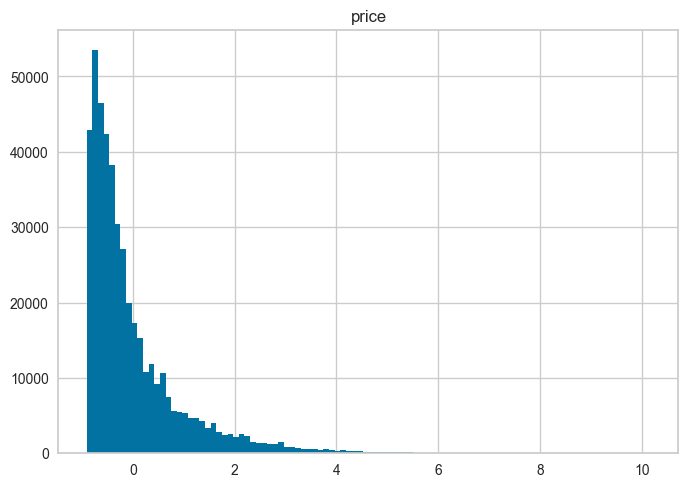

In [72]:
plot_hist(df_train[['price']],bins=100)

Предварительно : заполним  минимальным значением.

In [73]:
min_simple('price')
display(missing(df_train[['price']]),missing(df_test[['price']]))

,column_name,missing_values


,column_name,missing_values


#### 2.2.7 'requested_sum '- запрашиваемая сумма клиента для займа, если interface - alfa
####       'requested_amount' - запрашиваемая сумма клиента по займу
####   'req_app_amount' - разница между запрашиваемой суммой займа и одобренной

In [74]:
df_describe('requested_sum')

,requested_sum_train,requested_sum_test
count,489817.000000,163790.000000
mean,-0.000607,0.001816
std,0.997373,1.007819
min,-0.592014,-0.592014
25%,-0.462179,-0.462179
50%,-0.267427,-0.267427
75%,0.057159,0.057159
max,5.899720,5.899720


In [75]:
df_describe('requested_amount')

,requested_amount_train,requested_amount_test
count,3.621371e+06,1.209772e+06
mean,-2.585087e-04,7.738284e-04
std,9.997052e-01,1.000882e+00
min,-1.318104e+00,-1.318104e+00
25%,-8.330511e-01,-8.330511e-01
50%,-8.342339e-02,-8.342339e-02
75%,1.195353e+00,1.195353e+00
max,7.412853e+00,7.412853e+00


In [76]:
df_describe('req_app_amount')

,req_app_amount_train,req_app_amount_test
count,3.621371e+06,1.209772e+06
mean,-3.261837e-04,9.764088e-04
std,9.999505e-01,1.000148e+00
min,-5.241477e+00,-4.371254e+00
25%,-6.292957e-01,-6.292957e-01
50%,-1.071620e-01,-1.071620e-01
75%,6.760386e-01,6.760386e-01
max,5.636309e+00,5.636309e+00


In [77]:
df_test.query(' ~requested_amount.isna() and ~requested_sum.isna()')[['requested_amount','requested_sum']]

,requested_amount,requested_sum
6,1.239449,0.186994
50,1.239449,-0.267427
109,1.239449,-0.202510
184,1.239449,5.899720
217,1.239449,-0.592014
...,...,...
1348736,1.239449,-0.592014
1348737,-1.318104,-0.592014
1348738,-0.083423,-0.494638
1348739,1.239449,-0.592014


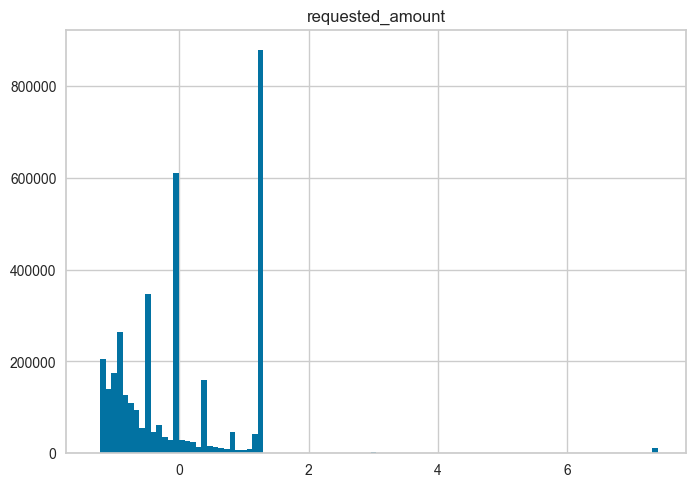

In [78]:
plot_hist(df_train[['requested_amount']],bins=100)

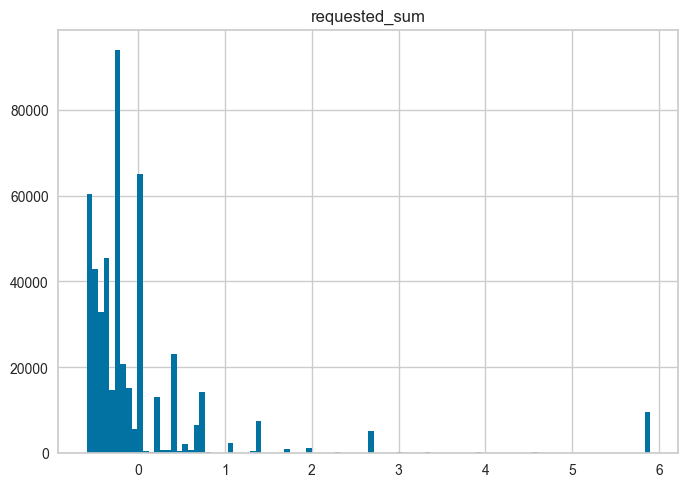

In [79]:
plot_hist(df_train[['requested_sum']],bins=100)

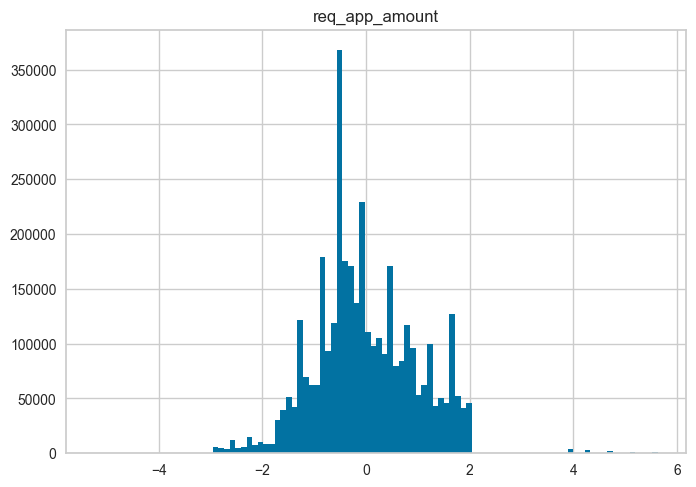

In [80]:
plot_hist(df_train[['req_app_amount']],bins=100)

In [81]:
df_train['requested_sum'] = df_train['requested_sum'].fillna(
            df_train['approved_amount'] * df_train['requested_sum'].mean() / df_train['approved_amount'].mean())

df_test['requested_sum'] = df_test['requested_sum'].fillna(
            df_test['approved_amount'] * df_test['requested_sum'].mean() / df_test['approved_amount'].mean())

In [82]:
df_train['requested_amount'] = df_train['requested_amount'].fillna(df_train['requested_sum'])
df_test['requested_amount'] =  df_test['requested_amount'].fillna(df_test['requested_sum'])

In [83]:
df_train['req_app_amount'] = df_train['req_app_amount'].fillna(df_train['requested_amount'] - df_train['approved_amount'])
df_test['req_app_amount'] =df_test['req_app_amount'].fillna( df_test['requested_amount'] - df_test['approved_amount'])

#### 2.2.8 'requested_period_days'  - запрашиваемый срок по займу

In [84]:
df_describe('requested_period_days')

,requested_period_days_train,requested_period_days_test
count,3.594589e+06,1.200882e+06
mean,3.266345e-04,-9.777119e-04
std,1.001271e+00,9.961864e-01
min,-1.657011e+00,-1.657011e+00
25%,-3.890285e-01,-3.890285e-01
50%,4.261034e-01,4.261034e-01
75%,4.261034e-01,4.261034e-01
max,1.401163e+01,1.401163e+01


In [85]:
df_train[['requested_period_days']].value_counts().count()

26

In [86]:
df_test[['requested_period_days']].value_counts().count()

26

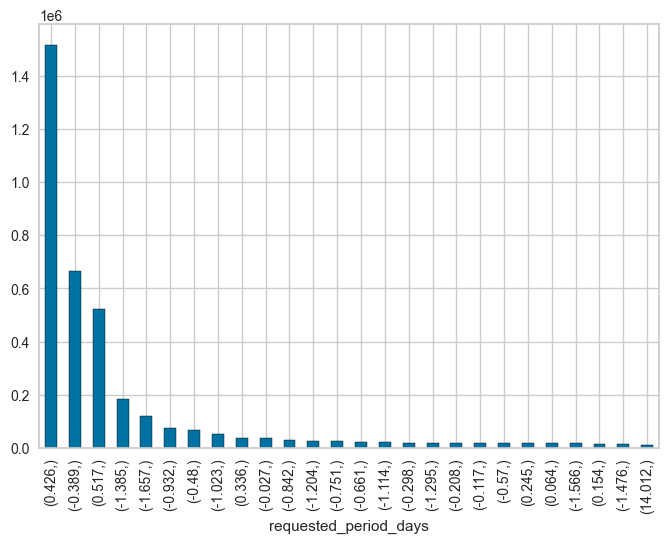

In [87]:
plot_bar(df_train[['requested_period_days']])

Предварительно:  заполним медианным  значением( здесь равна  моде)

In [88]:
simpl_median('requested_period_days')
display(missing(df_train[['requested_period_days']]),missing(df_test[['requested_period_days']]))

,column_name,missing_values


,column_name,missing_values


#### 2.2.9 tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)

In [89]:
df_describe('tamount')

,tamount_train,tamount_test
count,4.034433e+06,1.348125e+06
mean,1.909305e-04,-5.713835e-04
std,1.003192e+00,9.903851e-01
min,-9.813316e-01,-9.813261e-01
25%,-5.762984e-01,-5.736731e-01
50%,-2.610464e-01,-2.595385e-01
75%,2.935129e-01,2.935129e-01
max,2.821236e+02,1.553928e+02


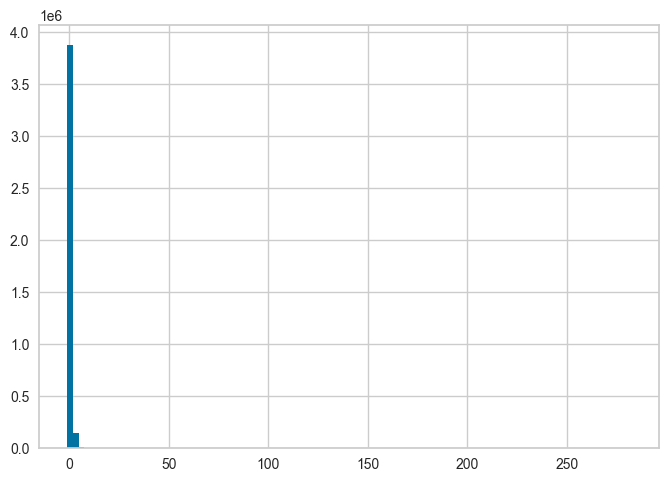

In [90]:
plot_hist(df_train['tamount'],bins=100)

In [91]:
df_train['tamount'].value_counts()

tamount
-0.799215    127136
-0.526033     84194
-0.617094     81395
-0.708154     77283
-0.434972     71024
              ...  
-0.739057         1
-0.735319         1
 0.281288         1
-0.172979         1
 0.894871         1
Name: count, Length: 281674, dtype: int64

Предварительно: заполним модой

In [92]:
def simple_moda(name):
    imp_mode = SimpleImputer(strategy="most_frequent")
    df_train[name]=imp_mode.fit_transform(df_train[[name]])
    df_test[name]=imp_mode.transform(df_test[[name]])

In [93]:
simple_moda('tamount')
display(missing(df_train[['tamount']]),missing(df_test[['tamount']]))

,column_name,missing_values


,column_name,missing_values


#### 2.2.10 Столбец `work_experiance`  кол-во лет стажа клиента

In [94]:
df_train['work_experience'].value_counts()

work_experience
 0.952894    556512
 0.084114    380849
-0.784665    272201
-1.653445    116386
-2.522225     61899
Name: count, dtype: int64

In [95]:
df_test['work_experience'].value_counts()

work_experience
 0.952894    185504
 0.084114    127539
-0.784665     90619
-1.653445     38743
-2.522225     20820
Name: count, dtype: int64

Признак содержит всего 5 уникальных значений, поэтому его можно рассматривать как категориальный. Для обработки пропусков целесообразно использовать отдельное значение, например, закодировать их как 0.

In [96]:
zerro_simple('work_experience')
display(missing(df_train[['work_experience']]),missing(df_test[['work_experience']]))

,column_name,missing_values


,column_name,missing_values


#### 2.2.11 term - срок пролонгации (список)

In [97]:
df_describe('term')

,term_train,term_test
count,453651.000000,151701.000000
mean,0.000688,-0.002058
std,1.000548,0.998362
min,-1.149255,-1.149255
25%,-0.561187,-0.561187
50%,-0.561187,-0.561187
75%,0.256993,0.256993
max,3.274034,5.575166


Предварительно:  пропуски в наблюдениях без пролонгации, заполним их минимальным значением.

In [98]:
min_simple('term')
display(missing(df_train[['term']]),missing(df_test[['term']]))

,column_name,missing_values


,column_name,missing_values


####  2.2.12  столбцы без пропусков

In [99]:
# columns_flat_no_na = set(df_train.select_dtypes(include='float').columns) -\
 # set(missing(df_train.select_dtypes(include='float'))['column_name'])

In [100]:
columns_flat_no_na=['ag',
'approved_amount',
'days_finish_loan',
'interest',
'issues',
'main_agreement_amount',
'main_agreement_term',
'overdue_fee',
'overdue_interest',
'period_days',
'principal']

In [101]:
df_train[columns_flat_no_na].describe()

,ag,approved_amount,days_finish_loan,interest,issues,main_agreement_amount,main_agreement_term,overdue_fee,overdue_interest,period_days,principal
count,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06,4.036207e+06
mean,7.153011e-05,7.910522e-05,1.464083e-04,2.708158e-04,1.431514e-05,-1.432715e-04,1.383222e-04,2.109503e-04,3.633334e-04,1.383222e-04,-1.431514e-05
std,9.998904e-01,1.000235e+00,1.000475e+00,1.002095e+00,9.978587e-01,1.000089e+00,1.000341e+00,9.992414e-01,1.001687e+00,1.000341e+00,9.978587e-01
min,-1.761946e+00,-1.152100e+00,-5.396155e-01,-5.028780e-01,-2.530519e+02,-9.858535e-01,-1.145865e+00,-1.857070e-01,-2.182650e-01,-1.145865e+00,-1.105251e+00
25%,-8.270634e-01,-7.512400e-01,-4.104309e-01,-4.778550e-01,-4.098445e-01,-6.870721e-01,-3.406587e-01,-1.857070e-01,-2.182650e-01,-3.406587e-01,-6.002189e-01
50%,-9.993219e-02,-2.167598e-01,-2.443364e-01,-3.152056e-01,2.845741e-01,-3.209154e-01,1.769741e-01,-1.857070e-01,-2.182650e-01,1.769741e-01,-2.845741e-01
75%,6.271990e-01,5.181504e-01,-4.422167e-03,5.763692e-02,6.002189e-01,5.080537e-01,1.769741e-01,-1.857070e-01,-2.182650e-01,1.769741e-01,4.098445e-01
max,4.470607e+00,9.938363e+00,1.651275e+01,6.156176e+01,1.105251e+00,1.141358e+01,8.804188e+00,4.719982e+01,1.460302e+02,8.804188e+00,2.530519e+02


###  2.3 Признаки 'int'

In [102]:
columns_int = df_train.select_dtypes(include=['int64', 'int32']).columns
columns_int

Index(['payment_frequency', 'status', 'loan_id', 'client_id', 'source',
       'first_source', 'interface', 'type', 'repayment_type', 'client_type',
       'loan_order', 'have_extension', 'created_at', 'start_dt', 'churn',
       'month', 'day', 'week', 'start_dt_xg', 'days_diff', 'days_diff_1'],
      dtype='object')

- payment_frequency - частота получения зарплаты (month - 1 раз в месяц, 2 weeks - раз в две недели, и тд)
- status - статус клиента (самозанятый, рабочий, и тд)
- source - канал привлечения клиента
- first_source - первый канал привлечения клиента
- interface - интерфейс, откуда пришла заявка - (site, mobile)
- type - тип займа (тип продукта)
- repayment_type - Тип комиссии по займу (с 2.5% - with_comission, 5% - with_big_comission, 0% - no_comission)
- client_type - тип клиента (новый, повторный)
- have_extension - имеется ли пролонгация по данному займу

In [103]:
list_int= ['payment_frequency', 'status','source', 'first_source',
         'interface', 'type', 'repayment_type', 'client_type','have_extension']
for i in list_int:
    print( i,np.sort(df_train[i].unique()))

payment_frequency [0 1 2 3 4 5 6 7]
status [0 1 2 3 4 5 6 7 8 9]
source [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
first_source [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
interface [0 1 2]
type [0 1 2 3]
repayment_type [0 1 2 3]
client_type [0 1]
have_extension [0 1]


In [104]:
list_int= ['payment_frequency', 'status','source', 'first_source',
         'interface', 'type', 'repayment_type', 'client_type','have_extension']
for i in list_int:
    print( i,np.sort(df_test[i].unique()))

payment_frequency [0 1 2 3 4 5 6 7]
status [0 1 2 3 4 5 6 7 8 9]
source [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
first_source [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
interface [0 1 2]
type [0 1 2 3]
repayment_type [0 1 2 3]
client_type [0 1]
have_extension [0 1]


Категориальные признаки в столбцах train и test имеют одинаковый набор уникальных значений.
payment_frequency - возможно  OrdinalEncoder лучше.

In [105]:
prepocessing.update({i:'one_hot' for i in list_int})
prepocessing

{'region_new': 'one_hot',
 'settlement_new': 'one_hot',
 'created_at': 'scale',
 ' start_dt': 'scale',
 'days_diff': 'scale',
 'start_dt_xg': 'scale',
 'client_type.1': 'one_hot',
 'gender': 'one_hot',
 'contact_cases': 'scale',
 'payment_frequency': 'one_hot',
 'status': 'one_hot',
 'source': 'one_hot',
 'first_source': 'one_hot',
 'interface': 'one_hot',
 'type': 'one_hot',
 'repayment_type': 'one_hot',
 'client_type': 'one_hot',
 'have_extension': 'one_hot'}

In [106]:
for i in ['loan_order', 'loan_id', 'client_id']:
    print(f'{i}: {len(Counter(df_train[i]))}')

loan_order: 352
loan_id: 4036207
client_id: 964899


In [107]:
for i in ['loan_order', 'loan_id', 'client_id']:
    print(f'{i}: {len(Counter(df_test[i]))}')

loan_order: 416
loan_id: 1348743
client_id: 321633


In [108]:
client_count=dict(Counter(pd.concat([df_train['client_id'],df_test['client_id']])))

In [109]:
df_train['client_id_new'] = df_train['client_id'].transform(lambda x: client_count.get(x)) 
df_test['client_id_new'] = df_test['client_id'].transform(lambda x: client_count.get(x)) 

In [110]:
client_count=dict(Counter(pd.concat([df_train['loan_order'],df_test['loan_order']])))

In [111]:
df_train['loan_order_new'] = df_train['loan_order'].transform(lambda x: client_count.get(x)) 
df_test['loan_order_new'] = df_test['loan_order'].transform(lambda x: client_count.get(x)) 

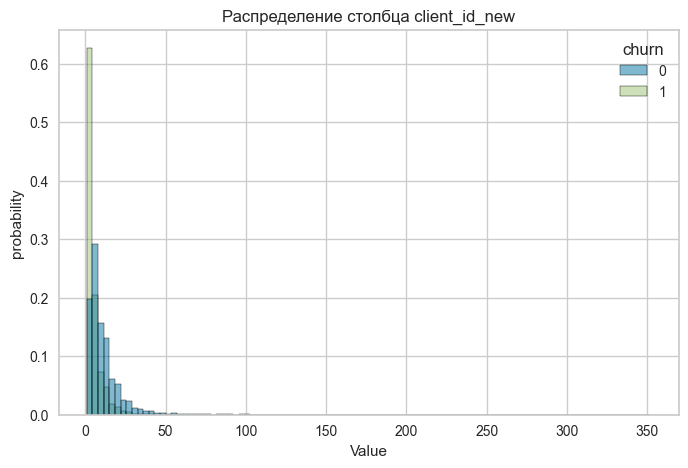

In [112]:
plot_hist_prob('client_id_new', df_train, bins=100)

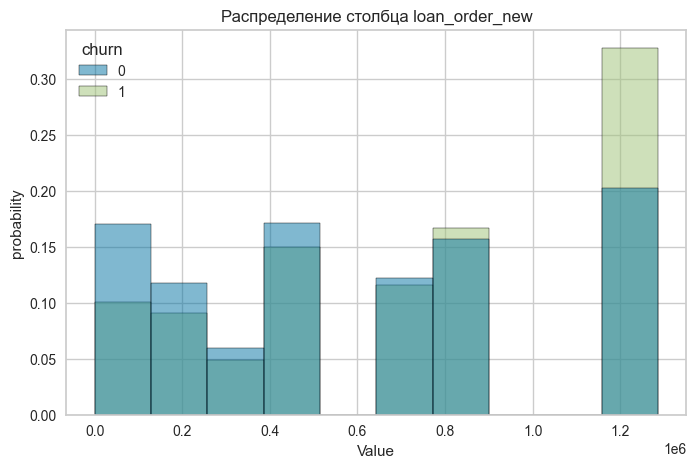

In [113]:
plot_hist_prob('loan_order_new',df_train,bins =10)

In [114]:
df_train['loan_order_new'].value_counts()

loan_order_new
1286532    964899
861517     646049
647654     485808
498755     373906
388090     290882
            ...  
15              9
14              8
11              6
2               6
9               5
Name: count, Length: 169, dtype: int64

In [115]:
prepocessing.update({'client_id_new':'scale', 'loan_order_new':'scale'})
prepocessing

{'region_new': 'one_hot',
 'settlement_new': 'one_hot',
 'created_at': 'scale',
 ' start_dt': 'scale',
 'days_diff': 'scale',
 'start_dt_xg': 'scale',
 'client_type.1': 'one_hot',
 'gender': 'one_hot',
 'contact_cases': 'scale',
 'payment_frequency': 'one_hot',
 'status': 'one_hot',
 'source': 'one_hot',
 'first_source': 'one_hot',
 'interface': 'one_hot',
 'type': 'one_hot',
 'repayment_type': 'one_hot',
 'client_type': 'one_hot',
 'have_extension': 'one_hot',
 'client_id_new': 'scale',
 'loan_order_new': 'scale'}

#### 2.3.1 'churn' **TARGET**

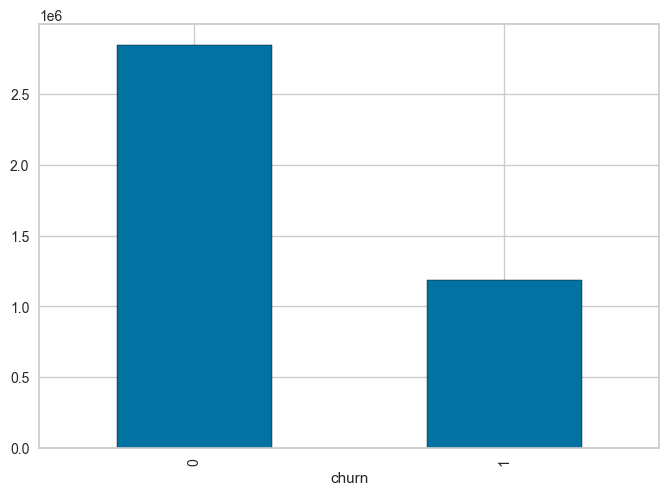

In [116]:
plot_bar(df_train['churn'])

Дисбаланс классов!

### 2.4 Новые признаки

In [117]:
df_train['early_repayment'] = df_train['period_days'] - df_train['days_finish_loan']
df_test['early_repayment'] = df_test['period_days'] - df_test['days_finish_loan']

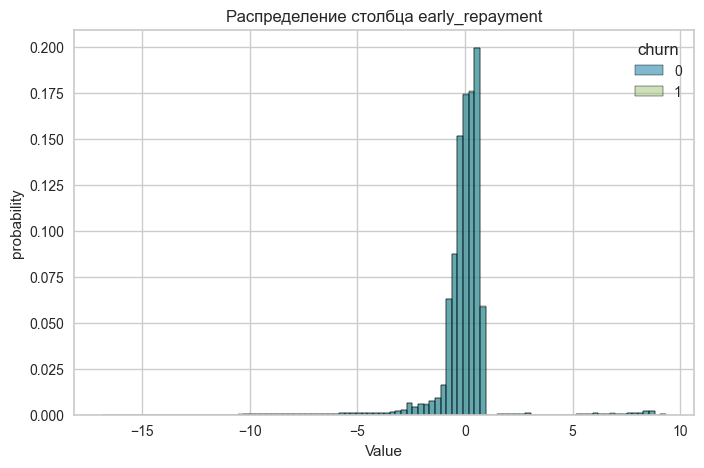

In [118]:
plot_hist_prob('early_repayment',df_train ,bins=100)

In [119]:
 df_train['approval_ratio'] = df_train['approved_amount'] / df_train['requested_amount']
 df_test['approval_ratio'] = df_test['approved_amount'] / df_test['requested_amount']

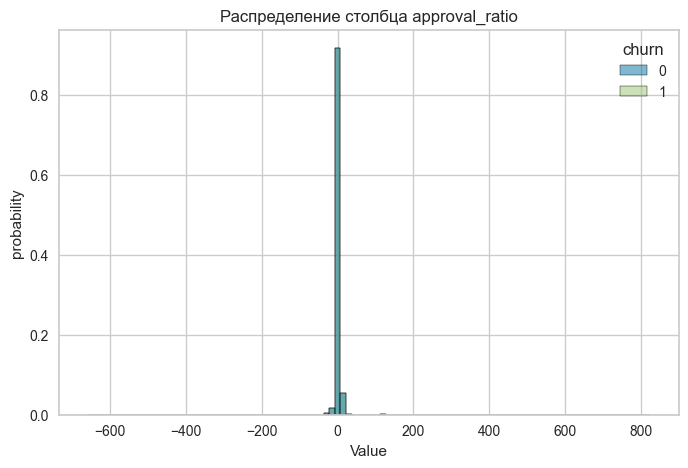

In [120]:
plot_hist_prob('approval_ratio',df_train,bins=100)

In [121]:
df_train['requested_approved_ratio'] = df_train['requested_period_days'] / df_train['main_agreement_term']
df_test['requested_approved_ratio'] =  df_test['requested_period_days'] / df_test['main_agreement_term']

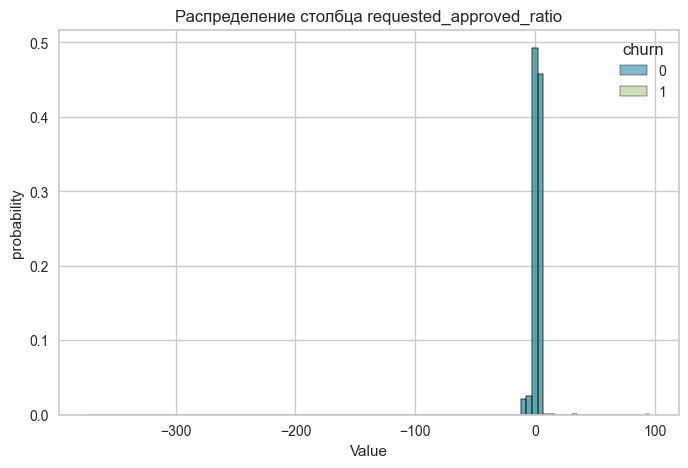

In [122]:
plot_hist_prob('requested_approved_ratio',df_train,bins=100)

In [123]:
df_train['requsted_income_ratio'] = df_train['requested_amount']/df_train['monthly_income']
df_test['requsted_income_ratio'] = df_test['requested_amount']/df_test['monthly_income']

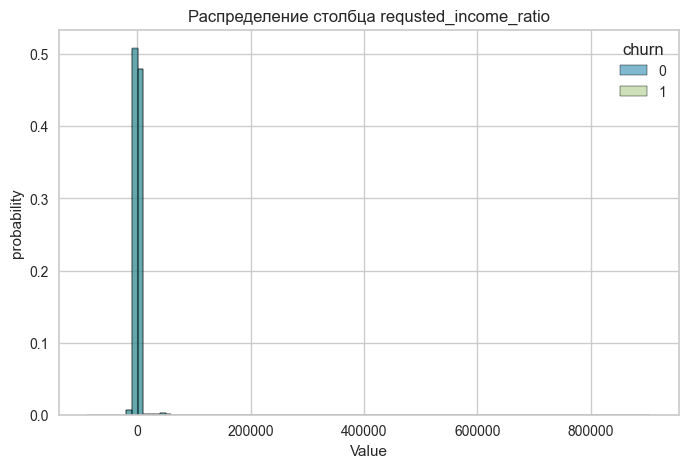

In [124]:
plot_hist_prob('requsted_income_ratio',df_train,bins=100)

In [125]:
df_train['total_debt_burden'] = (df_train['elecs_sum'] + df_train['recurents_sum']) / df_train['monthly_income']
df_test['total_debt_burden'] = (df_test['elecs_sum'] + df_test['recurents_sum']) / df_test['monthly_income']

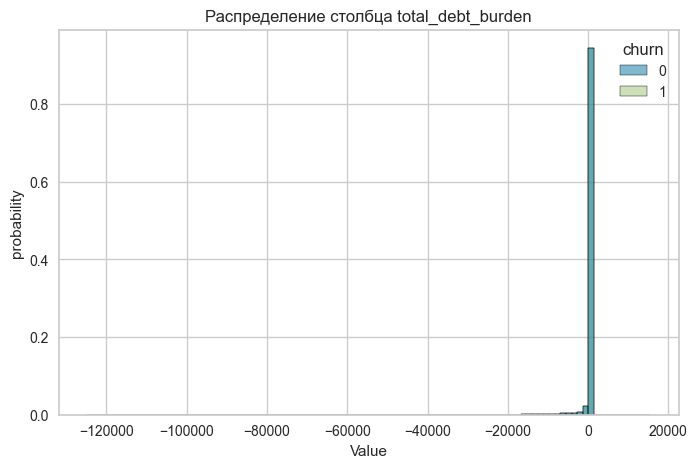

In [126]:
plot_hist_prob('total_debt_burden',df_train,bins=100)

In [127]:
df_train['dti'] = df_train['principal'] / df_train['monthly_income']
df_test['dti'] = df_test['principal']/ df_test['monthly_income']

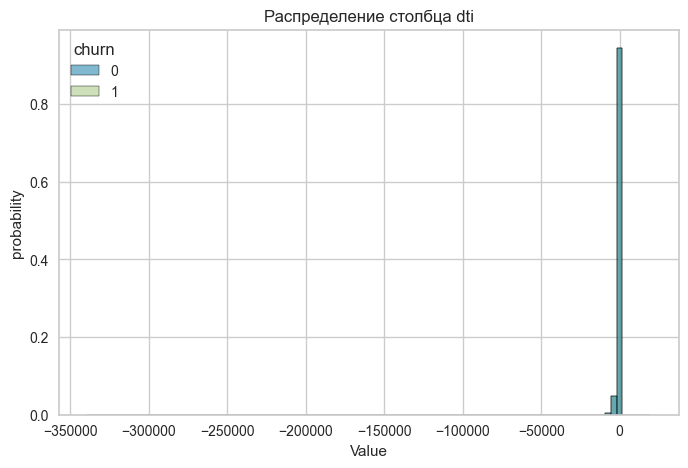

In [128]:
plot_hist_prob('dti',df_train,bins=100)

In [129]:
df_train[['early_repayment','approval_ratio','requsted_income_ratio','total_debt_burden','requested_approved_ratio','dti']].describe().round(3)

,early_repayment,approval_ratio,requsted_income_ratio,total_debt_burden,requested_approved_ratio,dti
count,4036207.000,4036207.000,4036207.000,4036207.000,4036207.000,4036207.000
mean,-0.000,0.918,177.749,-0.338,0.841,-2.023
std,1.331,15.789,3385.439,1902.177,4.818,1344.129
min,-16.853,-661.005,-89387.761,-124886.982,-374.058,-339521.228
25%,-0.275,-0.584,-1347.830,275.454,-0.621,-546.235
50%,0.144,0.320,112.901,276.342,1.446,382.913
75%,0.460,1.193,1053.510,277.663,2.408,801.944
max,9.344,825.261,905543.967,15554.345,96.190,19622.651


In [130]:
prepocessing.update({'early_repayment':'scale',
                     'approval_ratio':'scale',
                     'requsted_income_ratio':'scale',
                     'total_debt_burden':'scale',
                     'requested_approved_ratio':'scale',
                     'dti':'scale'
                    })

In [131]:
df_train[df_train.select_dtypes(include='int64').columns]=df_train.select_dtypes(include='int64').astype('int32')
df_test[df_test.select_dtypes(include='int64').columns]=df_test.select_dtypes(include='int64').astype('int32')

In [132]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 62 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   monthly_income            float64       
 1   work_experience           float64       
 2   requested_sum             float64       
 3   main_agreement_amount     float64       
 4   main_agreement_term       float64       
 5   requested_period_days     float64       
 6   requested_amount          float64       
 7   req_app_amount            float64       
 8   approved_amount           float64       
 9   period_days               float64       
 10  days_finish_loan          float64       
 11  ag                        float64       
 12  cnt_ext                   float64       
 13  term                      float64       
 14  price                     float64       
 15  elecs_sum                 float64       
 16  recurents_sum             float64       
 17  tamount 

### 3. Подготовка данных 

Разобъем  столбцы по категориям:

In [133]:
list_id_total = ['client_id_new', 'loan_order_new']
list_id = ['loan_id']
list_client= ['monthly_income','nbki_score','tamount','work_experience','ag','payment_frequency',
              'status','client_type','settlement_new','region_new','gender','client_type.1' ]

list_loan= ['cnt_ext','elecs_sum','recurents_sum','price','requested_amount',
            'req_app_amount','term','approved_amount','interest',
            'issues','main_agreement_amount','overdue_fee','overdue_interest','principal','type', 
             'repayment_type','have_extension','requested_sum']	
list_new = ['approval_ratio','early_repayment','requested_approved_ratio','requsted_income_ratio','total_debt_burden','dti']

list_support =[ 'contact_cases','source','first_source','interface'] 
list_time = [ 'month','day','week','days_finish_loan', 'period_days', 
             'requested_period_days','main_agreement_term','created_at','start_dt','days_diff']    
# 'closed_at','prolong','period', 'start_dt'->del

# проверка на дубли
total_list =list_id_total +list_loan+list_client+list_support+list_time + list_new
print('Дубли True-нет: ',len(total_list) == len (set(total_list)))
      
# проверка на идентичность структуры train test
print('Идентичность train, test: ',set(df_train.columns) ^set(df_test.columns))
# проверка на полноту  включения столбцов  в списки
print('Полнота столбцов в списке(:',set(df_train.columns) ^set(total_list))     

Дубли True-нет:  True
Идентичность train, test:  {'closed_at', 'churn'}
Полнота столбцов в списке(: {'loan_order', 'start_dt_new', 'loan_id', 'days_diff_1', 'client_id', 'settlement', 'closed_at', 'start_dt_xg', 'region', 'churn'}


Список столбцов, не включённых в total_list, ожидаемый.
total_list список признаков в  train для обучения, убедимся  в отсутсвии  пропусков)

In [134]:
display(missing (df_train[total_list]),missing (df_test[total_list]))

,column_name,missing_values


,column_name,missing_values


Проведем поиск  столбцов, для которых множества значений в test и train  равны.
Такие  признаки  можно рассматривать как категориальные

In [135]:
lenth_1, lenth_2 ={}, {}
for i in df_test.columns:
    lenth_1[i]=len(df_train[i].unique())
    lenth_2[i]=len(df_test[i].unique())

discrete_features ={key : value for key, value in lenth_1.items() if lenth_1.get(key) == lenth_2.get(key)}
discrete_features

{'work_experience': 6,
 'main_agreement_term': 34,
 'requested_period_days': 26,
 'period_days': 34,
 'payment_frequency': 8,
 'status': 10,
 'source': 20,
 'first_source': 19,
 'interface': 3,
 'type': 4,
 'repayment_type': 4,
 'client_type': 2,
 'client_type.1': 2,
 'gender': 2,
 'have_extension': 2,
 'region_new': 86,
 'month': 12,
 'day': 31,
 'week': 7}

_________
Блок записи  обработанных df_train, df_test(  если надо)

In [136]:
def load_df(df,name):
    os.makedirs('data',exist_ok=True)  
    df.to_csv(Path(Path.cwd()/'data'/f'{name}.csv'),index=False)

    

_______________________

In [137]:
#load_df(df_train, 'df_train_1')

In [138]:
def dict_features(data):
     return { f'list_{i}':list(data.select_dtypes(include=i).columns) for i in ['float','int','object']}
    

In [139]:
dict_list_feature = dict_features(df_train[total_list])

In [140]:
print(dict_list_feature)

{'list_float': ['cnt_ext', 'elecs_sum', 'recurents_sum', 'price', 'requested_amount', 'req_app_amount', 'term', 'approved_amount', 'interest', 'issues', 'main_agreement_amount', 'overdue_fee', 'overdue_interest', 'principal', 'requested_sum', 'monthly_income', 'nbki_score', 'tamount', 'work_experience', 'ag', 'contact_cases', 'days_finish_loan', 'period_days', 'requested_period_days', 'main_agreement_term', 'approval_ratio', 'early_repayment', 'requested_approved_ratio', 'requsted_income_ratio', 'total_debt_burden', 'dti'], 'list_int': ['client_id_new', 'loan_order_new', 'type', 'repayment_type', 'have_extension', 'payment_frequency', 'status', 'client_type', 'source', 'first_source', 'interface', 'month', 'day', 'week', 'created_at', 'start_dt', 'days_diff'], 'list_object': ['settlement_new', 'region_new', 'gender', 'client_type.1']}


In [141]:
df_test[total_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   client_id_new             1348743 non-null  int32  
 1   loan_order_new            1348743 non-null  int32  
 2   cnt_ext                   1348743 non-null  float64
 3   elecs_sum                 1348743 non-null  float64
 4   recurents_sum             1348743 non-null  float64
 5   price                     1348743 non-null  float64
 6   requested_amount          1348743 non-null  float64
 7   req_app_amount            1348743 non-null  float64
 8   term                      1348743 non-null  float64
 9   approved_amount           1348743 non-null  float64
 10  interest                  1348743 non-null  float64
 11  issues                    1348743 non-null  float64
 12  main_agreement_amount     1348743 non-null  float64
 13  overdue_fee               1

### 4. LGBM

In [142]:
# словарь  столбцов,  тоебующих кодирования/масшттабировния
prepocessing

{'region_new': 'one_hot',
 'settlement_new': 'one_hot',
 'created_at': 'scale',
 ' start_dt': 'scale',
 'days_diff': 'scale',
 'start_dt_xg': 'scale',
 'client_type.1': 'one_hot',
 'gender': 'one_hot',
 'contact_cases': 'scale',
 'payment_frequency': 'one_hot',
 'status': 'one_hot',
 'source': 'one_hot',
 'first_source': 'one_hot',
 'interface': 'one_hot',
 'type': 'one_hot',
 'repayment_type': 'one_hot',
 'client_type': 'one_hot',
 'have_extension': 'one_hot',
 'client_id_new': 'scale',
 'loan_order_new': 'scale',
 'early_repayment': 'scale',
 'approval_ratio': 'scale',
 'requsted_income_ratio': 'scale',
 'total_debt_burden': 'scale',
 'requested_approved_ratio': 'scale',
 'dti': 'scale'}

'list_int' -значения в столбцах кодировки не требуют.

In [143]:
# доп  анализ столбцов float,отнесенные к категориальным
set(discrete_features.keys()) -set( dict_list_feature.get('list_object'))- set( dict_list_feature.get('list_int'))

{'main_agreement_term',
 'period_days',
 'requested_period_days',
 'work_experience'}

In [144]:
# уникальные значения для списка выше
for i  in set(discrete_features.keys()) -set( dict_list_feature.get('list_object'))- set( dict_list_feature.get('list_int')):
    print(i, df_train[i].unique())

period_days [-3.40658735e-01 -1.14586537e+00 -6.85747291e-01  1.76974098e-01
 -3.98173495e-01  8.11401088e+00 -8.00776809e-01 -7.43262050e-01
 -9.73321087e-01  4.42982041e-03  2.34488858e-01 -6.28232532e-01
 -2.25629217e-01 -5.13203013e-01 -1.68114457e-01 -1.10599698e-01
 -4.55688254e-01 -5.30849389e-02 -5.70717772e-01  1.19459339e-01
 -1.03083585e+00 -8.58291569e-01  8.80418799e+00 -1.08835061e+00
 -2.83143976e-01 -9.15806328e-01  6.50359762e+00  6.19445797e-02
  2.47756447e+00  4.08797773e+00  3.28277110e+00  4.89318436e+00
  5.69839099e+00  7.30880425e+00]
work_experience [ 0.95289418 -1.65344512  0.         -0.78466535  0.08411442 -2.52222489]
requested_period_days [-0.38902847 -1.29473051 -1.1135901  -1.38530071 -1.65701133  0.42610336
 -0.02674766 -0.93244969 -1.0230199   0.15439275  0.51667357  0.33553316
 -0.66073908 -0.47959867 -0.29845827 -0.11731786 -0.57016888 -0.75130929
 -0.20788806 -0.84187949 -1.56644112 14.01163395 -1.20416031  0.06382255
 -1.47587092  0.24496296]
main

work_experience - категориальный

In [145]:
# Список столбцов для которых нужна кодировка
ordinal_coder_col = dict_list_feature.get('list_object')
scaler_coder_col = [ i  for i, value in prepocessing.items() if value == 'scale']

ordinal_coder_col, scaler_coder_col

(['settlement_new', 'region_new', 'gender', 'client_type.1'],
 ['created_at',
  ' start_dt',
  'days_diff',
  'start_dt_xg',
  'contact_cases',
  'client_id_new',
  'loan_order_new',
  'early_repayment',
  'approval_ratio',
  'requsted_income_ratio',
  'total_debt_burden',
  'requested_approved_ratio',
  'dti'])

In [146]:
list_scale = list(set((scaler_coder_col +dict_list_feature.get('list_float')))-{'work_experience'})

list_category = list(set(total_list) -set(list_scale))

In [147]:
scaler_coder_col, ordinal_coder_col

(['created_at',
  ' start_dt',
  'days_diff',
  'start_dt_xg',
  'contact_cases',
  'client_id_new',
  'loan_order_new',
  'early_repayment',
  'approval_ratio',
  'requsted_income_ratio',
  'total_debt_burden',
  'requested_approved_ratio',
  'dti'],
 ['settlement_new', 'region_new', 'gender', 'client_type.1'])

Итог:
- ordinal_coder - список  столбцов  для OrdinalEncoder
- scaler_coder - список  столбцов для Scaler
- list_scale список непрерывных признаков
- list_category - список категориальных признаков

monthly_income - увеличить в 100 раз ??? пока нет

## place  stoping

In [291]:
ordinal = OrdinalEncoder( handle_unknown='use_encoded_value', unknown_value=-1)
ordinal_cod =ordinal.fit_transform(df_train[ordinal_coder_col])
df_train[ordinal_coder_col] = pd.DataFrame(ordinal_cod, columns=ordinal_coder_col)

In [292]:
X_train, X_test, y_train, y_test =train_test_split(df_train[total_list],df_train['churn'], test_size=0.25, random_state=RANDOM_STATE, stratify=df_train['churn'])

In [294]:
model_lgbmc_1 = LGBMClassifier(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1,is_unbalance=True,
                               learning_rate=0.1,
                               n_estimators=530,
                               reg_alpha=1.0,
                               reg_lambda=0.6000000000000001
                                )

In [295]:
%%time
model_lgbmc_1.fit(X_train[total_list],  y_train )

CPU times: total: 6min 28s
Wall time: 3min 19s


LGBMClassifier(is_unbalance=True, n_estimators=530, random_state=51,
               reg_alpha=1.0, reg_lambda=0.6000000000000001, verbosity=-1)

accuracy:  0.9447877810063307
precision:  0.9831397331728358
recall:  0.8262925205626356
f1:  0.89791812488319


C:\Users\dmitr\AppData\Local\Temp\ipykernel_10280\638291066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)


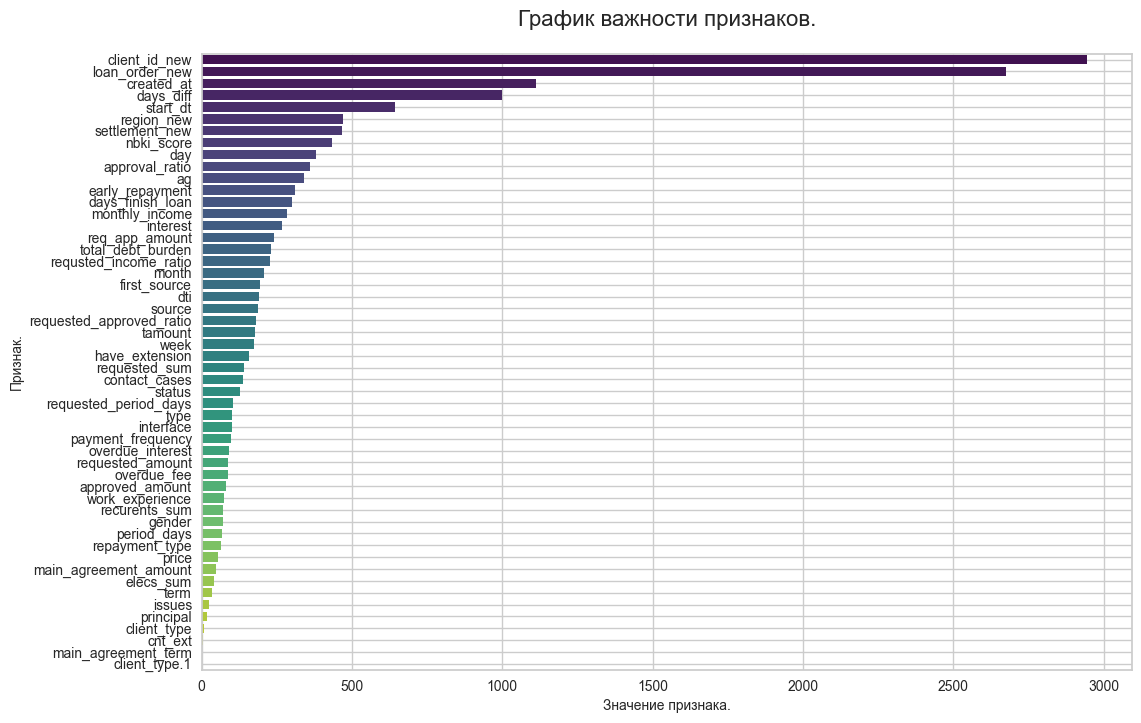

CPU times: total: 59.8 s
Wall time: 32.1 s


In [296]:
%%time
pred_1=model_lgbmc_1.predict(X_test[total_list])
score(y_test,pred_1)

plot_features( model_lgbmc_1.feature_importances_,total_list)

In [153]:
sorted(zip(model_lgbmc_1.feature_importances_,total_list), reverse=True)

[(2946, 'client_id_new'),
 (2675, 'loan_order_new'),
 (1113, 'created_at'),
 (1000, 'days_diff'),
 (643, 'start_dt'),
 (471, 'region_new'),
 (467, 'settlement_new'),
 (433, 'nbki_score'),
 (381, 'day'),
 (360, 'approval_ratio'),
 (342, 'ag'),
 (310, 'early_repayment'),
 (302, 'days_finish_loan'),
 (283, 'monthly_income'),
 (267, 'interest'),
 (241, 'req_app_amount'),
 (230, 'total_debt_burden'),
 (227, 'requsted_income_ratio'),
 (206, 'month'),
 (194, 'first_source'),
 (190, 'dti'),
 (186, 'source'),
 (180, 'requested_approved_ratio'),
 (178, 'tamount'),
 (174, 'week'),
 (156, 'have_extension'),
 (140, 'requested_sum'),
 (139, 'contact_cases'),
 (128, 'status'),
 (105, 'requested_period_days'),
 (102, 'type'),
 (100, 'interface'),
 (99, 'payment_frequency'),
 (92, 'overdue_interest'),
 (88, 'requested_amount'),
 (86, 'overdue_fee'),
 (82, 'approved_amount'),
 (73, 'work_experience'),
 (72, 'recurents_sum'),
 (71, 'gender'),
 (67, 'period_days'),
 (66, 'repayment_type'),
 (54, 'price'),

In [314]:
pred_train = model_lgbmc_4.predict_proba(X_train[total_list])

In [315]:
def stack_pred (pred_train,):
    pred_1 = np.where(pred_train> 0.1, 1, 0)
    pred_2 = np.where(pred_train> 0.2, 1, 0)
    pred_3 = np.where(pred_train> 0.3, 1, 0)
    pred_4 = np.where(pred_train> 0.4, 1, 0)
    pred_5 = np.where(pred_train> 0.5, 1, 0)
    return np.hstack((pred_1,pred_2,pred_3,pred_4,pred_5))


X_stack =stack_pred(pred_train)

model_stack = LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1)

model_stack.fit(X_stack, y_train)

pred_test = model_lgbmc_4.predict_proba(X_test[total_list])

X_stack_test = stack_pred(pred_test)

pred = model_stack.predict(X_stack_test)

score(y_test,pred)

C:\Users\dmitr\anaconda3\envs\env_NLP\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dmitr\anaconda3\envs\env_NLP\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


accuracy:  0.9459492672330069
precision:  0.9955237755908575
recall:  0.819760363939258
f1:  0.8991329950139816


In [ ]:
accuracy:  0.9457441241878516
precision:  0.9913670468309258
recall:  0.822539144041304
f1:  0.8990963328031377

#### 4.1  Feature Selection

In [ ]:
list_feature, f1=[],[]

model_feature =LGBMClassifier(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1,is_unbalance=True,
                               learning_rate=0.1,
                               n_estimators=530,
                               reg_alpha=1.0,
                               reg_lambda=0.6000000000000001
                                )
for i in tqdm(sorted(zip(model_lgbmc_1.feature_importances_,total_list), reverse=True)):
    list_feature.append(i[1])
    model_feature.fit(X_train[list_feature], y_train)
    f1.append(f1_score(y_test, model_feature.predict(X_test[list_feature])))
    print(list_feature,f1)

In [254]:
f2 = f1[:-1]
f2.insert(0, f1[0])

df_features_1 = pd.DataFrame({'columns':[ i for _,i in sorted(zip(model_lgbmc_1.feature_importances_,total_list), reverse=True)],
                              'delta':(np.array(f1)- np.array(f2))*1000}).sort_values(by='delta', ascending=False)


total_list_features_1 = df_features_1.query('delta >= 0')['columns'].tolist()

In [247]:
total_list_features_1 

['loan_order_new',
 'days_diff',
 'interface',
 'interest',
 'first_source',
 'contact_cases',
 'gender',
 'approved_amount',
 'have_extension',
 'price',
 'term',
 'region_new',
 'elecs_sum',
 'ag',
 'requsted_income_ratio',
 'cnt_ext',
 'tamount',
 'approval_ratio',
 'settlement_new',
 'dti',
 'week',
 'client_type',
 'main_agreement_term',
 'client_id_new',
 'client_type.1']

4.6125

In [179]:
from sklearn.inspection import permutation_importance

permutation = permutation_importance(model_lgbmc_1, X_test[total_list], y_test, scoring = 'f1') 

In [257]:
df_features_2=pd.DataFrame({'columns': X_test[total_list].columns,'importances_mean': permutation.importances_mean*1000000}).sort_values(
                           by='importances_mean',ascending=False)

total_list_features_2 = df_features_2.query('importances_mean >= 0')['columns'].tolist()

In [266]:
%%time
list_cross_val =[]
for i in [total_list, total_list_features_1, total_list_features_2]:
  list_cross_val.append(cross_val_score(model_lgbmc_1, df_train[i], df_train['churn'], cv=5, scoring='f1').mean())

CPU times: total: 1h 39min 32s
Wall time: 52min 13s


In [274]:
list_cross_val

[0.8979840492287039, 0.8980016992059386, 0.8979195502233754]

In [270]:
from imblearn.ensemble import BalancedBaggingClassifier

balanced_bagging = BalancedBaggingClassifier(
    estimator=model_lgbmc_1,  
    n_estimators=20,            
    sampling_strategy='auto',    
    random_state=RANDOM_STATE,    
    n_jobs=-1                    
)



In [154]:
%%time
balanced_bagging.fit(X_train[total_list], y_train)

CPU times: total: 11.1 s
Wall time: 32min 38s


BalancedBaggingClassifier(estimator=LGBMClassifier(is_unbalance=True,
                                                   n_estimators=530,
                                                   random_state=51,
                                                   reg_alpha=1.0,
                                                   reg_lambda=0.6000000000000001,
                                                   verbosity=-1),
                          n_estimators=20, n_jobs=-1, random_state=51)

In [156]:
%%time
pred_1=balanced_bagging.predict(X_test[total_list])
score(y_test,pred_1)

accuracy:  0.9448383234957167
precision:  0.983943037160859
recall:  0.8257698131405273
f1:  0.8979440664323419
CPU times: total: 10.7 s
Wall time: 9min 4s


In [ ]:
plot_features( model_lgbmc_1.feature_importances_,total_list)

In [ ]:
balansbalanced_bagging

#### 4.1 thershold

In [222]:
pred_proba_1 = model_lgbmc_1.predict_proba(X_test)[:,1]

In [217]:
pred_proba_1

array([0.14762003, 0.12624824, 0.99789749, ..., 0.22032409, 0.08273619,
       0.01018249])

In [249]:
f1=[]
for i in tqdm(np.linspace(0.3,0.8,200)):
    pred = np.where(pred_proba_1 > i, 1, 0)
    
    f1.append(f1_score(y_test, pred))
threshold=np.linspace(0.3,0.8,200)[f1.index(max(f1))]    
threshold

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:22<00:00,  1.40it/s]


0.6668341708542713

### Hpyperparameter tuning

In [ ]:
param = { 
    'model__learning_rate': distributions.FloatDistribution(0.01, 0.1, step=0.005),  
    'model__n_estimators': distributions.IntDistribution(200, 1000, step=10),  
    'model__num_leaves': distributions.IntDistribution(20, 300, step=10),  
    'model__min_child_samples': distributions.IntDistribution(5, 100, step=5), 
    'model__reg_alpha': distributions.FloatDistribution(0.0, 5.0, step=0.1),  
    'model__reg_lambda': distributions.FloatDistribution(0.0, 10.0, step=0.1) 
}


model_lgbmc_2= LGBMClassifier(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1,class_weight='balanced')

oscv = OptunaSearchCV(
        model_lgbmc_2,
        param,
        scoring='f1',
        n_jobs=-1,
        cv=3,
        n_trials=20,
        random_state=RANDOM_STATE,
        verbose=False
    )

In [ ]:
%%time
oscv.fit(X_train,y_train)

print(oscv.best_score_)
print(oscv.best_estimator_)

In [ ]:
pred_oscv = oscv.predict(X_test)
score(y_test,pred_oscv)

In [154]:
param_grid = {
    'learning_rate': np.linspace(0.01, 0.1, num=3),  # От 0.01 до 0.1 с шагом ~0.01
    'n_estimators': np.linspace(400, 1000, num=3, dtype=int),  # 200, 400, 600, 800, 1000
    # 'num_leaves': np.linspace(20, 300, num=3, dtype=int),  # 20, 70, 120, 170, 220, 270, 300
    # 'min_child_samples': np.linspace(5, 100, num=3, dtype=int),  # 5, 30, 55, 80, 100
    #'reg_alpha': np.linspace(0.0, 5.0, num=3),  # 0.0, 1.0, 2.0, 3.0, 4.0, 5.0
    'reg_lambda': np.linspace(0.0, 10.0, num=3),  # 0.0, 2.0, 4.0, 6.0, 8.0, 10.0
    'scale_pos_weight': np.linspace(2, 4.0, num=5)  # 2.0, 2.5, 3.0, 3.5, 4.0
}

model_lgbmc_2 = LGBMClassifier(
    boosting_type='gbdt',
    random_state=RANDOM_STATE,
    verbosity=-1,
    class_weight=None  
)

grid_search = GridSearchCV(
    model_lgbmc_2,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=3,
    verbose=1
)

In [ ]:
grid_search.fit(X_test[total_list], y_test)

In [157]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший f1-score:", grid_search.best_score_)

Лучшие параметры: {'learning_rate': 0.05500000000000001, 'n_estimators': 1000, 'reg_lambda': 5.0, 'scale_pos_weight': 2.0}
Лучший f1-score: 0.8979416832642283


In [165]:
grid_search.best_params_

{'learning_rate': 0.05500000000000001,
 'n_estimators': 1000,
 'reg_lambda': 5.0,
 'scale_pos_weight': 2.0}

In [168]:
model_lgbmc_2 = LGBMClassifier(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1,
                               learning_rate=0.05500000000000001,
                               n_estimators=1000,
                               # reg_alpha=1.0,
                               reg_lambda=5,
                               scale_pos_weight= 2.0)

In [170]:
%%time
model_lgbmc_2.fit(X_train[total_list],  y_train)

CPU times: total: 12min 7s
Wall time: 6min 22s


LGBMClassifier(learning_rate=0.05500000000000001, n_estimators=1000,
               random_state=51, reg_lambda=5, scale_pos_weight=2.0,
               verbosity=-1)

accuracy:  0.9452188787099178
precision:  0.9866975993544482
recall:  0.8247075367665656
f1:  0.8984593567396484


C:\Users\dmitr\AppData\Local\Temp\ipykernel_1432\638291066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)


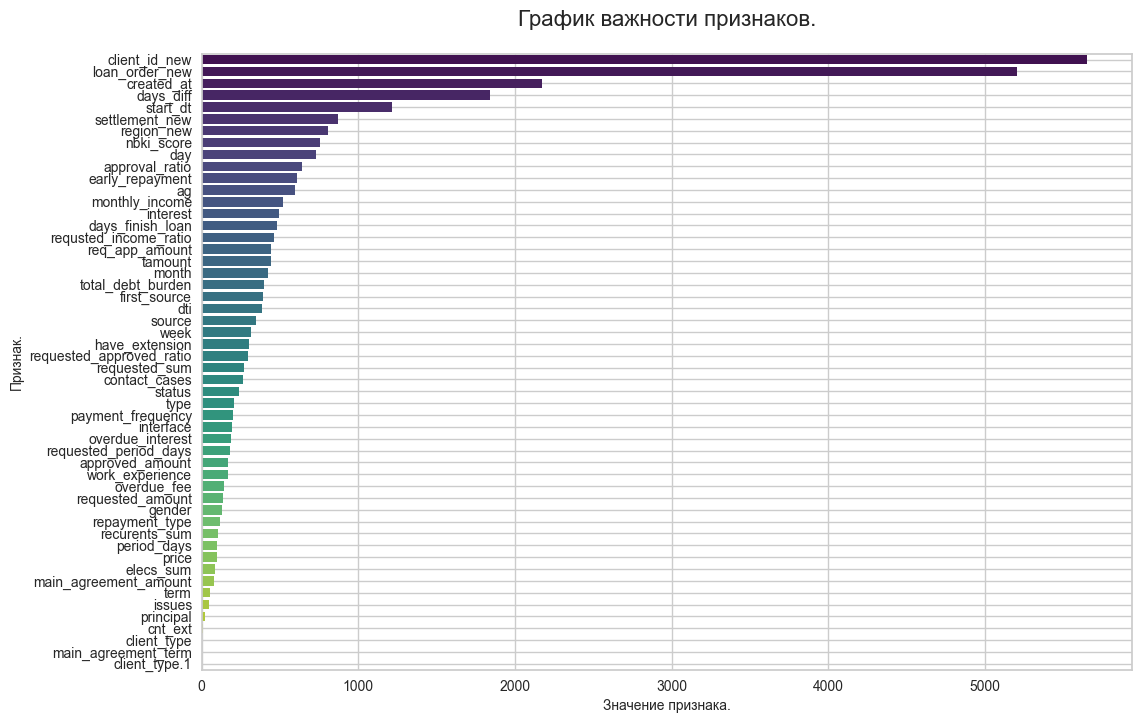

CPU times: total: 2min 16s
Wall time: 1min 12s


In [181]:
%%time
pred_1=model_lgbmc_2.predict(X_test[total_list])
score(y_test,pred_1)

plot_features( model_lgbmc_2.feature_importances_,total_list)

In [312]:
model_lgbmc_4 =LGBMClassifier(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1,
                               learning_rate=0.05500000000000001,
                               n_estimators=1250,
                               reg_alpha=0,
                               reg_lambda=5,
                               scale_pos_weight= 1.5,
                               class_weight=None)

In [313]:
model_lgbmc_4.fit(X_train[total_list],y_train)

LGBMClassifier(learning_rate=0.05500000000000001, n_estimators=1250,
               random_state=51, reg_alpha=0, reg_lambda=5, scale_pos_weight=1.5,
               verbosity=-1)

accuracy:  0.9457441241878516
precision:  0.9913670468309258
recall:  0.822539144041304
f1:  0.8990963328031377


C:\Users\dmitr\AppData\Local\Temp\ipykernel_1432\638291066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)


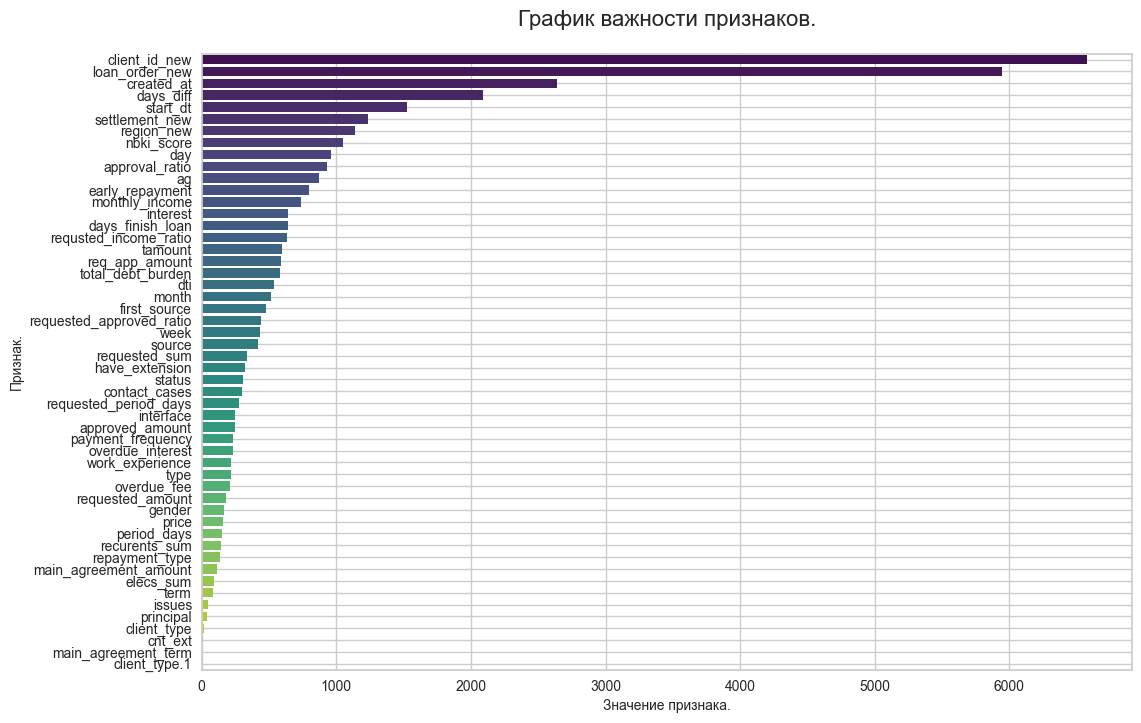

CPU times: total: 3min 24s
Wall time: 1min 58s


In [182]:
%%time
pred_1=model_lgbmc_4.predict(X_test[total_list])
score(y_test,pred_1)

plot_features( model_lgbmc_4.feature_importances_,total_list)

In [208]:
%%time
model_lgbmc_4.fit(X_train[total_list],y_train)

CPU times: total: 17min 22s
Wall time: 8min 57s


LGBMClassifier(learning_rate=0.05500000000000001, n_estimators=1250,
               random_state=51, reg_alpha=0, reg_lambda=5, scale_pos_weight=1.5,
               verbosity=-1)

In [ ]:
%%time
pred_1=model_lgbmc_4.predict(X_test[total_list])
score(y_test,pred_1)

plot_features( model_lgbmc_4.feature_importances_,total_list)

#### 5. XGBOOST

In [155]:
from xgboost import XGBClassifier

In [156]:
scale_pos_weight = df_train['churn'].value_counts()[0]/df_train['churn'].value_counts()[1]
scale_pos_weight

In [157]:
xgboost_1 = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, eval_metric='logloss')


In [160]:
%%time
xgboost_1.fit(X_train, y_train)

CPU times: total: 3min 18s
Wall time: 59.3 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=51, ...)

accuracy:  0.9446639023558746
precision:  0.9827785399667847
recall:  0.8261778621603666
f1:  0.897699770068613


C:\Users\dmitr\AppData\Local\Temp\ipykernel_10384\638291066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)


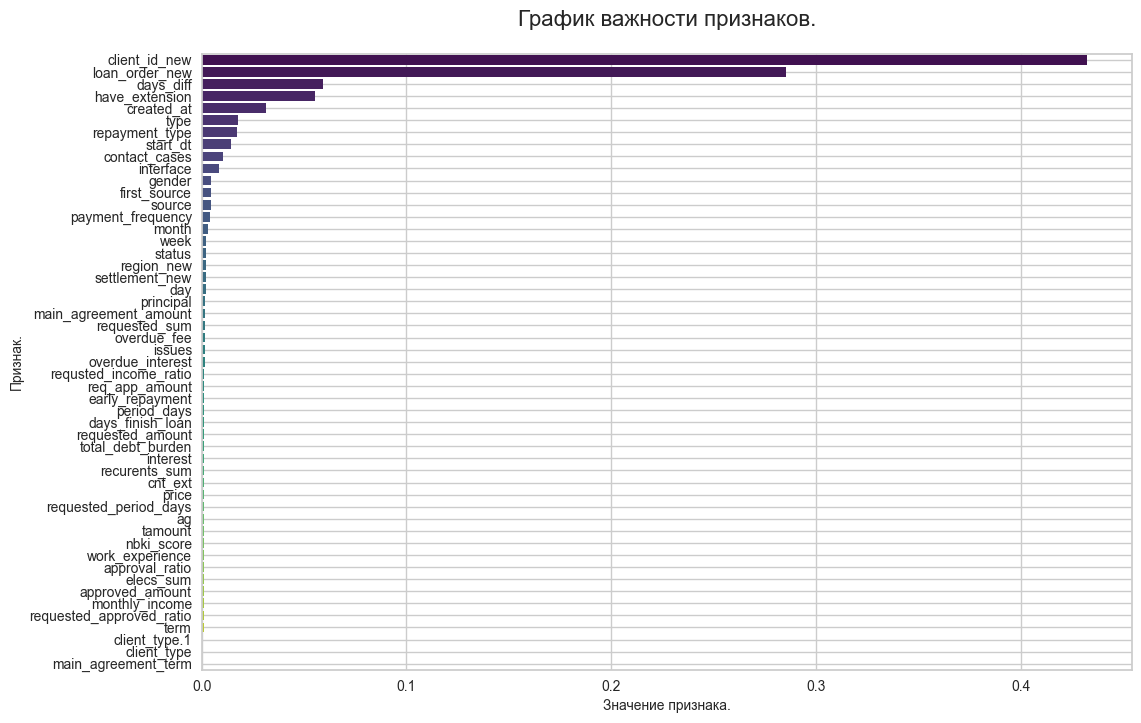

CPU times: total: 11.9 s
Wall time: 6.55 s


In [161]:
%%time
pred_1=xgboost_1.predict(X_test)
score(y_test,pred_1)

plot_features( xgboost_1.feature_importances_,total_list)

In [ ]:
param = { 
    'model__learning_rate': distributions.FloatDistribution(0.01, 0.1, step=0.005),  
    'model__n_estimators': distributions.IntDistribution(200, 1000, step=10),  
    'model__max_depth': distributions.IntDistribution(3, 15, step=1),   
    'model__min_child_weight': distributions.IntDistribution(1, 10, step=1),  
    'model__reg_alpha': distributions.FloatDistribution(0.0, 5.0, step=0.1),  
    'model__reg_lambda': distributions.FloatDistribution(0.0, 10.0, step=0.1),
    'model__scale_pos_weight': distributions.FloatDistribution(1, 10, step=0.1)
}

In [161]:
oscv_1 = OptunaSearchCV(
        xgboost_1,
        param,
        # scoring='f1',
        n_jobs=-1,
        cv=3,
        n_trials=30,
        random_state=RANDOM_STATE,
        verbose=False
    )

In [162]:
oscv_1.fit(X_train,y_train)

C:\Users\dmitr\anaconda3\envs\env_NLP\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:01:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda" } are not used.

  warnings.warn(smsg, UserWarning)


OptunaSearchCV(cv=3,
               estimator=XGBClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric='logloss',
                                       feature_types=None, gamma=None,
                                       grow_policy=None, importance_type=None,
                                       interaction_constraints=None,
                                       learning_rat...
                                    'model__max_depth': IntDistribution(high=15, log=False, low=3, step=1),
                                    'model__min_child_weight': IntDistribution(high=10, log=False, low=1, step=1),
                                    'model__n_estimators': IntDistribution(high=1000, log=False, low=200, step=10),
                                    'model__reg_alpha': FloatDistribution(high=5.0, log=False, low=0.0, step=0.1),
                                    'model__reg_lambda': FloatDistribution(high=10.0, log=False, low=0.0, step=0.1)},
               random_state=51, verbose=False)

In [163]:
oscv_1.best_score_

0.9444851684304024

In [164]:
oscv_1.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

accuracy:  0.9445618263478989
precision:  0.9824422796963292
recall:  0.8261171606532831
f1:  0.8975236406402849


C:\Users\dmitr\AppData\Local\Temp\ipykernel_13148\638291066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)


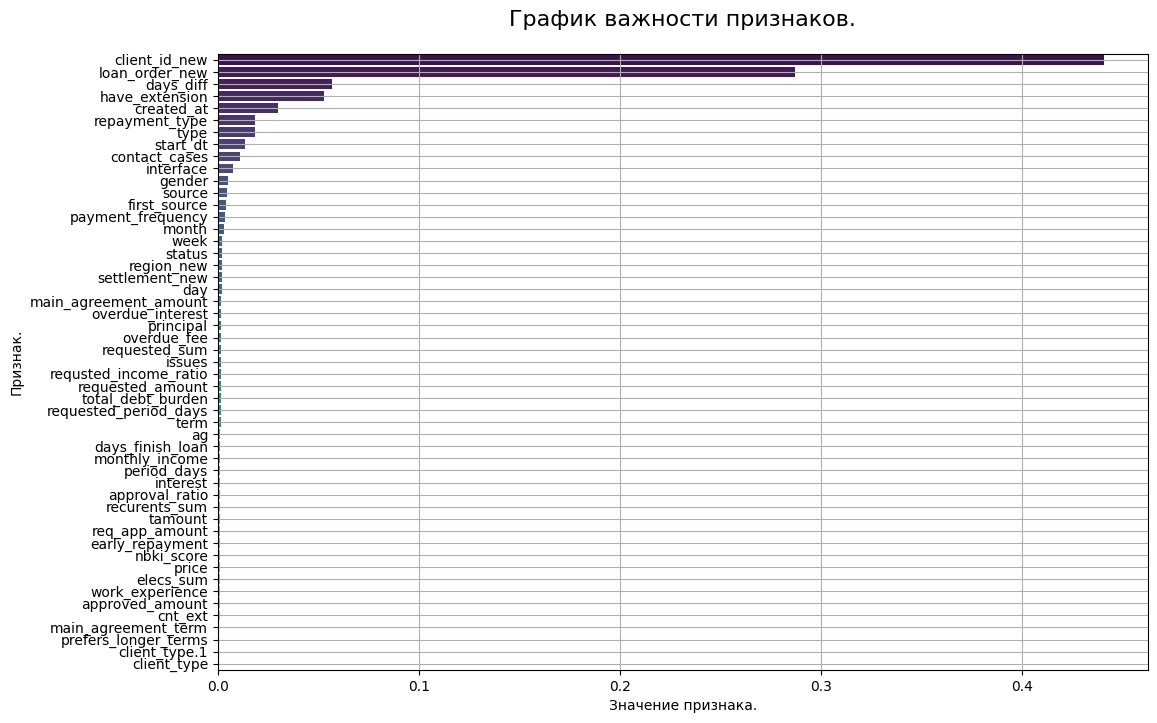

CPU times: total: 11.7 s
Wall time: 6.43 s


In [165]:
%%time
pred_1=oscv_1.predict(X_test)
score(y_test,pred_1)

plot_features( oscv_1.best_estimator_.feature_importances_,total_list)


In [171]:
oscv_1.best_params_

{'model__learning_rate': 0.015,
 'model__n_estimators': 910,
 'model__max_depth': 13,
 'model__min_child_weight': 10,
 'model__reg_alpha': 5.0,
 'model__reg_lambda': 1.6}

In [178]:
oscv_1.study_.trials_dataframe()
    

,number,value,datetime_start,datetime_complete,duration,params_model__learning_rate,params_model__max_depth,params_model__min_child_weight,params_model__n_estimators,params_model__reg_alpha,...,user_attrs_mean_score_time,user_attrs_mean_test_score,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,system_attrs_terminator:cv_scores,state
0,0,0.944485,2025-02-04 16:56:50.629393,2025-02-04 17:06:20.032269,0 days 00:09:29.402876,0.035,12,5,420,0.4,...,8.897433,0.944485,0.944449,0.944482,0.944525,19.842697,1.471909,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE
1,1,0.944485,2025-02-04 16:56:50.645511,2025-02-04 17:06:18.921068,0 days 00:09:28.275557,0.055,6,7,610,1.1,...,9.344259,0.944485,0.944449,0.944482,0.944525,21.492786,1.082919,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE
2,2,0.944485,2025-02-04 16:56:50.653704,2025-02-04 17:06:17.902803,0 days 00:09:27.249099,0.015,13,10,910,5.0,...,8.205052,0.944485,0.944449,0.944482,0.944525,20.071619,2.129068,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE
3,3,0.944485,2025-02-04 16:56:50.664326,2025-02-04 17:06:19.488400,0 days 00:09:28.824074,0.065,9,5,850,5.0,...,9.211372,0.944485,0.944449,0.944482,0.944525,20.657049,0.971299,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE
4,4,0.944485,2025-02-04 17:06:17.933498,2025-02-04 17:15:39.886269,0 days 00:09:21.952771,0.065,13,10,820,1.8,...,7.399222,0.944485,0.944449,0.944482,0.944525,39.493048,0.765101,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE
5,5,0.944485,2025-02-04 17:06:18.925129,2025-02-04 17:15:48.488255,0 days 00:09:29.563126,0.015,6,7,550,2.6,...,6.223654,0.944485,0.944449,0.944482,0.944525,35.119915,1.611015,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE
6,6,0.944485,2025-02-04 17:06:19.491446,2025-02-04 17:15:43.090639,0 days 00:09:23.599193,0.085,13,3,510,2.2,...,8.188985,0.944485,0.944449,0.944482,0.944525,37.753224,1.522231,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE
7,7,0.944485,2025-02-04 17:06:20.035270,2025-02-04 17:15:42.230923,0 days 00:09:22.195653,0.020,13,10,380,4.6,...,8.396470,0.944485,0.944449,0.944482,0.944525,37.010962,1.372776,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE
8,8,0.944485,2025-02-04 17:15:39.890512,2025-02-04 17:26:20.283867,0 days 00:10:40.393355,0.075,11,3,500,4.7,...,9.355352,0.944485,0.944449,0.944482,0.944525,27.783014,1.109698,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE
9,9,0.944485,2025-02-04 17:15:42.233924,2025-02-04 17:26:18.567562,0 days 00:10:36.333638,0.070,7,8,820,3.4,...,9.807739,0.944485,0.944449,0.944482,0.944525,28.651332,1.462615,0.000031,"[0.9444488490186829, 0.9444815529824033, 0.944...",COMPLETE


### 6.1 catboost

In [151]:
from catboost import CatBoostClassifier

In [152]:
categorical_feature = ['settlement_new', 'region_new', 'gender', 'client_type.1']

In [154]:

model_сatboost = CatBoostClassifier(random_state=RANDOM_STATE,auto_class_weights="Balanced") 

In [156]:
%%time
model_сatboost.fit(X_train[total_list], y_train, cat_features=categorical_feature, verbose=100)

Learning rate set to 0.315745
0:	learn: 0.5161267	total: 5.31s	remaining: 1h 28m 22s
100:	learn: 0.2299634	total: 6m 14s	remaining: 55m 31s
200:	learn: 0.2260441	total: 11m 54s	remaining: 47m 21s
300:	learn: 0.2246031	total: 18m 28s	remaining: 42m 55s
400:	learn: 0.2234755	total: 24m 23s	remaining: 36m 26s
500:	learn: 0.2223754	total: 30m 6s	remaining: 29m 59s
600:	learn: 0.2214364	total: 36m 14s	remaining: 24m 3s
700:	learn: 0.2204851	total: 43m 25s	remaining: 18m 31s
800:	learn: 0.2196751	total: 51m 2s	remaining: 12m 40s
900:	learn: 0.2188265	total: 57m 58s	remaining: 6m 22s
999:	learn: 0.2180345	total: 1h 4m 42s	remaining: 0us
CPU times: total: 3h 27min 59s
Wall time: 1h 5min 25s


accuracy:  0.9443992975585005
precision:  0.9811678721096386
recall:  0.826666846522984
f1:  0.8973153821938167


C:\Users\dmitr\AppData\Local\Temp\ipykernel_10280\638291066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)


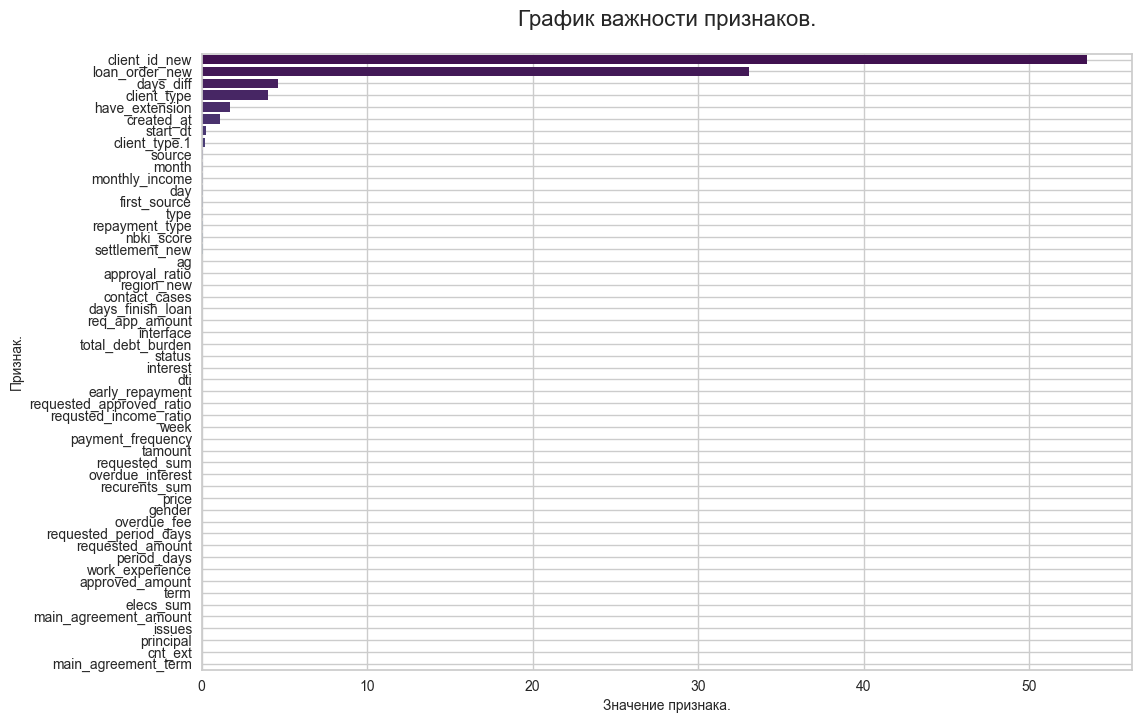

CPU times: total: 27.2 s
Wall time: 12.7 s


In [159]:
%%time
pred_1=model_сatboost.predict(X_test[total_list])
score(y_test,pred_1)

plot_features( model_сatboost.feature_importances_,total_list)

In [163]:
sorted(zip(model_сatboost.feature_importances_*100,total_list), reverse=True)

[(5350.829178698146, 'client_id_new'),
 (3307.060185962765, 'loan_order_new'),
 (463.58161754239023, 'days_diff'),
 (403.4808858619106, 'client_type'),
 (173.01900166819408, 'have_extension'),
 (110.02334357623305, 'created_at'),
 (27.079887753436143, 'start_dt'),
 (17.502579055929832, 'client_type.1'),
 (10.119823258307491, 'source'),
 (8.88021177379114, 'month'),
 (7.426270957488584, 'monthly_income'),
 (7.383049131808468, 'day'),
 (6.822517281663934, 'first_source'),
 (6.6026658786880965, 'type'),
 (6.513454723049135, 'repayment_type'),
 (6.321880762955106, 'nbki_score'),
 (5.39275333072202, 'settlement_new'),
 (4.842399820843299, 'ag'),
 (4.573954631052214, 'approval_ratio'),
 (4.536691361760882, 'region_new'),
 (4.3976745635897085, 'contact_cases'),
 (3.888196735786494, 'days_finish_loan'),
 (3.789939885097276, 'req_app_amount'),
 (3.7278199218753714, 'interface'),
 (3.649145650825746, 'total_debt_burden'),
 (3.6480965912697996, 'status'),
 (3.455464436828414, 'interest'),
 (3.150

In [173]:
pred_proba_cat=model_сatboost.predict_proba(X_test[total_list])[:,1]

In [177]:
f1=[]
for i in tqdm(np.linspace(0.3,0.8,200)):
    pred_proba = np.where(pred_proba_cat> i, 1, 0)
    
    f1.append(f1_score(y_test, pred_proba))
threshold, f1_=np.linspace(0.3,0.8,200)[f1.index(max(f1))] , max(f1)
threshold, f1_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.02it/s]


(0.7020100502512563, 0.8992268984615612)

In [198]:
pred_cat = np.where(pred_proba_cat> 0.25, 1, 0)

In [199]:
score(y_test,pred_cat)

accuracy:  0.8722593087373098
precision:  0.7355351231657216
recall:  0.88269770986703
f1:  0.8024249112884065


In [272]:
pred_train = model_сatboost.predict_proba(X_train[total_list])

### 6. SVM

In [ ]:
param = { 
    'models__kernel': distributions.Categorical(['rbf', 'sigmoid', 'linear']),
    'models__C': distributions.Float(0.1, 20),
    'models__gamma': distributions.Float(0.1, 20),
    'preprocessor__num': distributions.Categorical(['standard', 'minmax'])
}

In [ ]:
svc_scale_list = list(set(df_train[total_list].select_dtypes(include='float64').columns)-set(ordinal_coder_col)) +['client_id_new', 'loan_order_new']+\
                ['month', 'day', 'week', 'created_at', 'days_diff', 'start_dt_xg']

svc_ord_list = ['client_type.1', 'gender']

svc_passthrough_list = ['payment_frequency']

svc_oneh_list = list_int.copy()
svc_oneh_list.remove('payment_frequency')

svc_has_list = ['region_new','settlement_new']

set(svc_scale_list+svc_oneh_list+svc_passthrough_list+svc_has_list+svc_ord_list )^set(total_list)

In [326]:
df_train[total_list].select_dtypes(include=['int32','int_64').columns

Index(['client_id_new', 'loan_order_new', 'type', 'repayment_type',
       'have_extension', 'payment_frequency', 'status', 'client_type',
       'source', 'first_source', 'interface', 'month', 'day', 'week',
       'created_at', 'days_diff', 'start_dt_xg'],
      dtype='object')

In [173]:
preprocessing =ColumnTransformer([
    ('scaler', StandardScaler(),svc_scale_list ),
    ('ohot', OneHotEncoder( handle_unknown='infrequent_if_exist'),svc_oneh_list),
    ('has_1', HashingEncoder(n_components=100), 'settlement_new'),
    ('has_2' , HashingEncoder(n_components=20), 'region_new'),
    ('ordinal', OrdinalEncoder( handle_unknown='use_encoded_value', unknown_value=-1), svc_ord_list),
    ('pass', 'passthrough', svc_passthrough_list)
])

In [174]:
pipe_svc = Pipeline([
    ('preprocessing', preprocessing),
    ( 'svc', SVC(class_weight='balanced', random_state=RANDOM_STATE))
 ])

In [ ]:
%%time 
pipe_svc.fit(X_train[:100000], y_train[:100000])

### 6.2 FFN


Решение  для FFN  в отдельном ноутбуке.

### 6.3 TabNet


Решение  для TabNet  в отдельном ноутбуке.

### 7. Stacking

In [209]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


In [462]:
model_lgbmc_stack = LGBMClassifier(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1,scale_pos_weight=4.5,
                               learning_rate=0.1,
                               n_estimators=530,
                               reg_alpha=1.0,
                               reg_lambda=0.6000000000000001
                                )

xgboost_stack = XGBClassifier(scale_pos_weight=3, random_state=RANDOM_STATE, eval_metric='logloss')
estimator = LogisticRegression()


In [453]:
base_model = [
    ('lgbm', model_lgbmc_stack),
    ('xg', xgboost_stack)
]

In [454]:
%%time
stacking_model = StackingClassifier(estimators=base_model, final_estimator=estimator)
stacking_model.fit(X_train, y_train)

CPU times: total: 56min 2s
Wall time: 26min 35s


StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(class_weight='balanced',
                                               n_estimators=530,
                                               random_state=51, reg_alpha=1.0,
                                               reg_lambda=0.6000000000000001,
                                               verbosity=-1)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_cat...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=51, ...))],
                   final_estimator=LogisticRegression())

In [455]:
score(y_test, stacking_model.named_estimators_['lgbm'].predict(X_test))

accuracy:  0.9447620142470359
precision:  0.9831573624838977
recall:  0.8261879790782138
f1:  0.897863747475821


In [456]:
score(y_test, stacking_model.named_estimators_['xg'].predict(X_test))

accuracy:  0.895823010112462
precision:  0.7960583909994463
recall:  0.8678325852434636
f1:  0.8303974495080687


In [460]:
%%time
y_pred = stacking_model.predict(X_test)

CPU times: total: 1min 5s
Wall time: 31.7 s


In [461]:
score(y_test,y_pred)

accuracy:  0.9444865081284215
precision:  0.9813979368402512
recall:  0.8267680157014565
f1:  0.8974711903123307


In [ ]:
accuracy:  0.9447620142470359
precision:  0.9831573624838977
recall:  0.8261879790782138
f1:  0.897863747475821

### 8.  submission

In [195]:
ordinal_cod =ordinal.transform(df_test[ordinal_coder_col])
df_test[ordinal_coder_col] = pd.DataFrame(ordinal_cod, columns=ordinal_coder_col)

In [250]:
model_lgbmc_final =  LGBMClassifier(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1,class_weight='balanced',
                               learning_rate=0.1,
                               n_estimators=530,
                               reg_alpha=1.0,
                               reg_lambda=0.6000000000000001
                                )

In [251]:
model_lgbmc_final.fit( df_train[total_list], df_train['churn'])

LGBMClassifier(class_weight='balanced', n_estimators=530, random_state=51,
               reg_alpha=1.0, reg_lambda=0.6000000000000001, verbosity=-1)

In [196]:
pred_2 =model_lgbmc_4.predict_proba(df_test[total_list_features_1])[:,1]

In [204]:
threshold

0.3864321608040201

In [205]:
pred_2 = np.where(pred_2 > threshold, 1, 0)

In [277]:
np.sum((pred+pred_2)[(pred+pred_2) ==1])

733

In [ ]:
pred_cat = model_сatboost.predict_proba(df_test[total_list])[:,1]

In [183]:
pred_2  =  np.where(pred_cat > threshold, 1, 0)

In [184]:
def load_sab(data, name):
    
    submission = pd.DataFrame({
        'loan_id': df_test['loan_id'].values,
        'churn': data
})
    submission.to_csv(f'{name}.csv', index=False)

In [185]:
load_sab(pred_2, 'submittion_final_3')

### 9. Model Improvement

воспользуемся следеющим алгоритмом:

создадим df_train['period'] = (df_train['closed_at']-df_train['created_at']).dt.days

обучим модель, используя LGBMRegressor, предсказывать df_train['period'] | 'closed_at'

Заменим df_train['period']. период на предсказанные значения, создадим в test['period']

продублируем 'start_dt_dubl' = 'start_dt (безлайн сделан с другим алгоритмом заполнения)

заполним пропуски в 'start_dt_dubl' значениями 'closed_at' в предположении что пропуски -наблюдения без пролонгаций

добавим признак ['prolong'] = .apply( lambda x: 0 if pd.isna(x.start_dt) else max(1,(x.closed_at-x.start_dt_dubl).days), axis=1)

переобучим модель используя новые признаки( включая start_dt и без него)

реализация в пункте 6

In [268]:
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'])
df_train['start_dt_new'] = df_train['start_dt_new'].fillna(df_train['closed_at'])
df_train[['closed_at','start_dt_new']] =df_train[['closed_at','start_dt_new']].astype('int64')//10**9//86400
df_train['period'] = (df_train['closed_at']-df_train['created_at'])
df_train['prolong'] = df_train['closed_at']-df_train['start_dt_new']

period =list(range(0,100,10))+list(range(100,600,50)) +[float('inf')]
period.insert(0,-1)

df_train['period_cut']=pd.cut(df_train['period'],period, labels=range(len(period) - 1)).astype('int64')


KeyboardInterrupt



In [ ]:
# df_train['prolong'] = df_train.apply( 
    # lambda x:  0  if pd.isna(x.start_dt_new) else max(1,(x.closed_at - x.start_dt_new).days), axis=1)

In [ ]:
df_train[['start_dt_new','closed_at','period','prolong','period_cut']].info()

In [ ]:
list_time = [ 'month','day','week','days_finish_loan', 'period_days', 
             'requested_period_days','main_agreement_term','created_at','days_diff']  

In [ ]:
total_list =list_id_total +list_loan+list_client+list_support+list_time + list_new

In [ ]:
list_time_add =['start_dt_new','closed_at','prolong','period_cut']
total_list = total_list+list_time_add

In [ ]:
df_train['closed_at'] = pd.to_datetime(df_train['closed_at']).astype('int64')//10**9//86400

df_train['period'] = (df_train['closed_at']-df_train['created_at'])

In [ ]:
df_train[['closed_at','created_at']].info()

In [280]:
df_train['closed_at'].describe().round(3)

count    4036207.000
mean       19695.983
std          211.898
min        19101.000
25%        19541.000
50%        19716.000
75%        19874.000
max        20028.000
Name: closed_at, dtype: float64

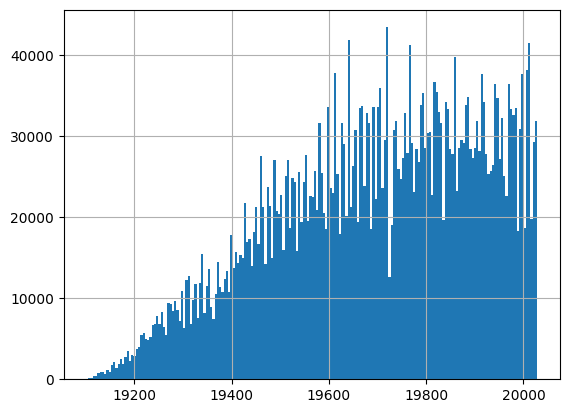

In [275]:
plot_hist(df_train['closed_at'], bins=200)

In [318]:
total_list_improv = total_list

In [319]:
X_train, X_test, y_train, y_test = train_test_split(df_train[total_list_improv], df_train['closed_at'], random_state=RANDOM_STATE)

In [320]:
lgbmr_1 =LGBMRegressor(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1,
                               learning_rate=0.1,
                               n_estimators=530,
                               reg_alpha=1.0,
                               reg_lambda=0.6000000000000001
                                )

In [321]:
%%time
lgbmr_1.fit(X_train, y_train)

CPU times: total: 5min 17s
Wall time: 2min 52s


LGBMRegressor(n_estimators=530, random_state=51, reg_alpha=1.0,
              reg_lambda=0.6000000000000001, verbosity=-1)

RMSE:  44.83562214296051
MAE:  19.35634113695942
R2:  0.9551661120845718


C:\Users\dmitr\AppData\Local\Temp\ipykernel_9264\638291066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)


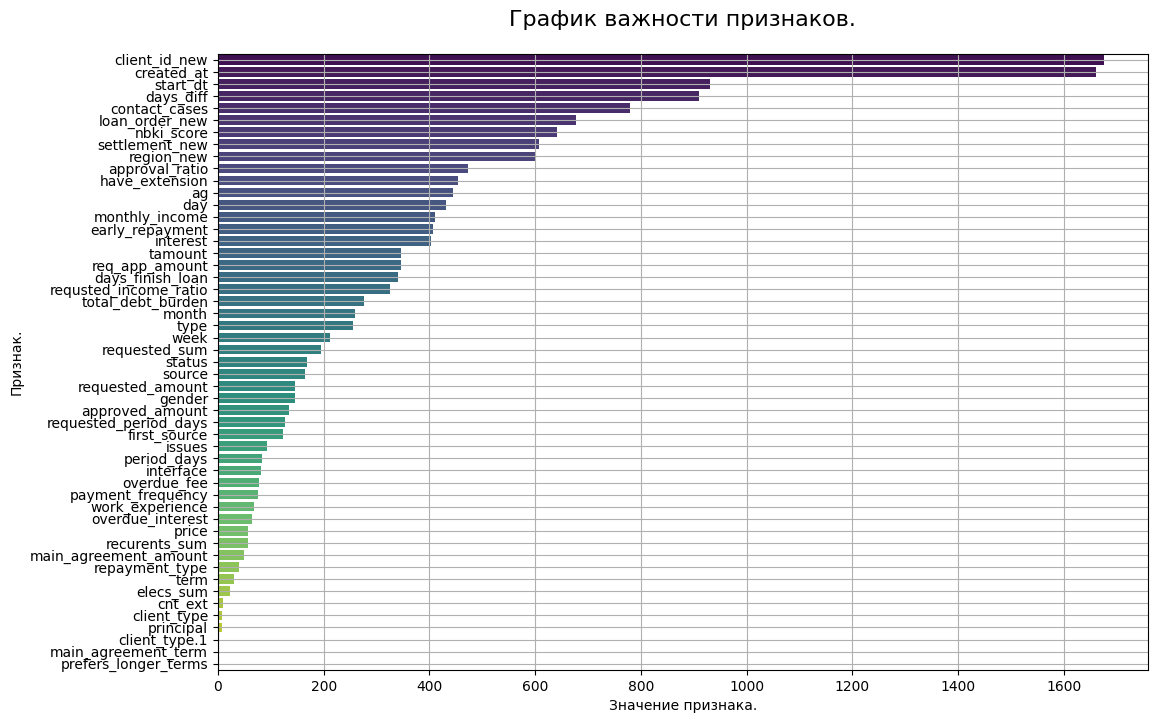

In [324]:
pred_reg = lgbmr_1.predict(X_test)
score_reg(y_test,pred_reg)
plot_features( lgbmr_1.feature_importances_,total_list_improv)

In [325]:
%%time
df_train['closed_at_new'] = lgbmr_1.predict(df_train[total_list_improv]).astype('int64')


CPU times: total: 3min 33s
Wall time: 2min 1s


In [330]:
df_train['period'] = (df_train['closed_at_new']-df_train['created_at'])


In [ ]:
df_train['start_dt_new'] = df_train['start_dt_new'].fillna(data['closed_at_new']).astype('int64')
df_train['prolong'] = df_train.apply( 
    lambda x:  0  if pd.isna(x.start_dt) else max(1,(x.closed_at-x.start_dt).days), axis=1)

In [331]:
total_list_improv_2 = total_list+ ['closed_at_new','period']

In [332]:
model_lgbmc_2 = LGBMClassifier(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1,class_weight='balanced',
                               learning_rate=0.1,
                               n_estimators=530,
                               reg_alpha=1.0,
                               reg_lambda=0.6000000000000001
                                )

In [335]:
X_train, X_test, y_train, y_test = train_test_split(df_train[total_list_improv_2], df_train['churn'], random_state=RANDOM_STATE)

In [336]:
%%time
model_lgbmc_2.fit(X_train, y_train)

CPU times: total: 7min 28s
Wall time: 4min 11s


LGBMClassifier(class_weight='balanced', n_estimators=530, random_state=51,
               reg_alpha=1.0, reg_lambda=0.6000000000000001, verbosity=-1)

accuracy:  0.94443992975585
precision:  0.9808766566361483
recall:  0.8269823116032239
f1:  0.897379341146925


C:\Users\dmitr\AppData\Local\Temp\ipykernel_9264\638291066.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='value', y='feature', data=df, palette='viridis', legend=False)


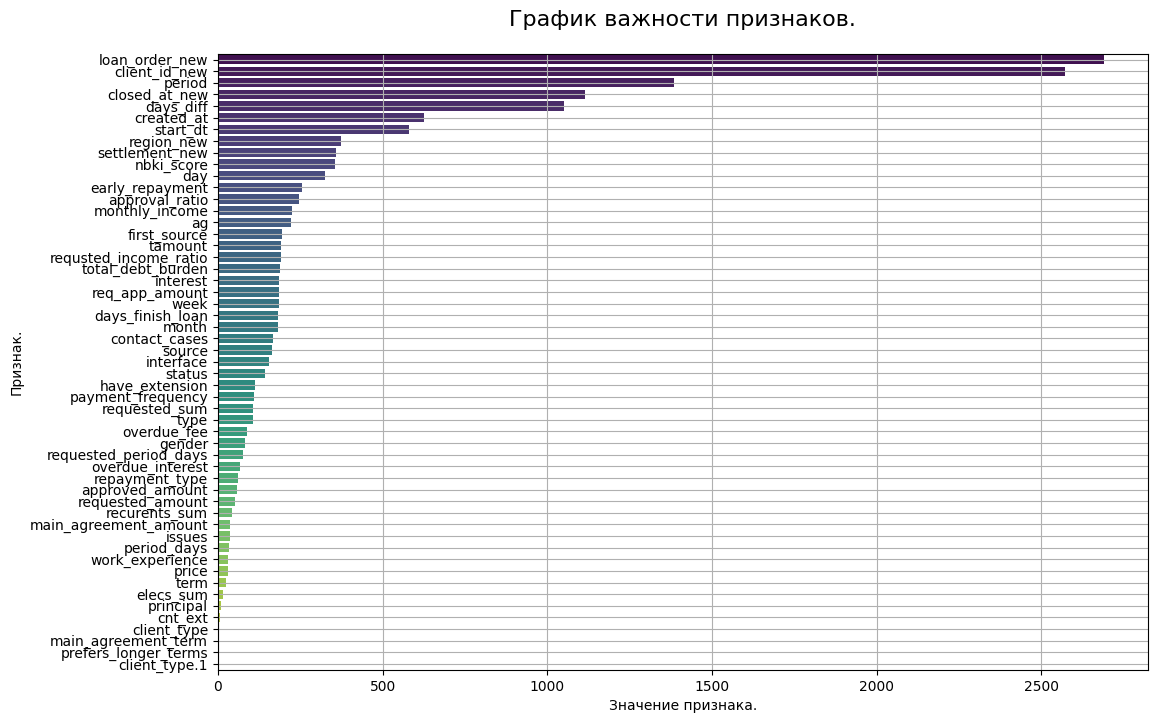

CPU times: total: 1min 12s
Wall time: 42.7 s


In [337]:
%%time
pred_2=model_lgbmc_2.predict(X_test)
score(y_test,pred_2)

plot_features( model_lgbmc_2.feature_importances_,total_list_improv_2)

In [355]:
sorted(zip(model_lgbmc_2.feature_importances_,total_list_improv_2))

[(0, 'client_type.1'),
 (0, 'main_agreement_term'),
 (0, 'prefers_longer_terms'),
 (4, 'client_type'),
 (7, 'cnt_ext'),
 (10, 'principal'),
 (15, 'elecs_sum'),
 (26, 'term'),
 (30, 'price'),
 (30, 'work_experience'),
 (33, 'period_days'),
 (37, 'issues'),
 (38, 'main_agreement_amount'),
 (44, 'recurents_sum'),
 (52, 'requested_amount'),
 (58, 'approved_amount'),
 (61, 'repayment_type'),
 (68, 'overdue_interest'),
 (76, 'requested_period_days'),
 (81, 'gender'),
 (87, 'overdue_fee'),
 (108, 'requested_sum'),
 (108, 'type'),
 (110, 'payment_frequency'),
 (113, 'have_extension'),
 (144, 'status'),
 (155, 'interface'),
 (164, 'source'),
 (166, 'contact_cases'),
 (181, 'month'),
 (182, 'days_finish_loan'),
 (184, 'week'),
 (186, 'req_app_amount'),
 (187, 'interest'),
 (190, 'total_debt_burden'),
 (192, 'requsted_income_ratio'),
 (192, 'tamount'),
 (195, 'first_source'),
 (223, 'ag'),
 (226, 'monthly_income'),
 (247, 'approval_ratio'),
 (254, 'early_repayment'),
 (326, 'day'),
 (357, 'nbki_s

____________________________
test

In [340]:
ordinal_cod =ordinal.transform(df_test[ordinal_coder_col])
df_test[ordinal_coder_col] = pd.DataFrame(ordinal_cod, columns=ordinal_coder_col)

In [342]:
%%time
df_test['closed_at_new'] = lgbmr_1.predict(df_test[total_list_improv]).astype('int64')

CPU times: total: 1min 16s
Wall time: 47.9 s


In [352]:
df_test['period'] = (df_test['closed_at_new']-df_test['created_at'])

In [353]:
pred_test_2 = model_lgbmc_2.predict(df_test[total_list_improv_2])

In [347]:
pred_test_2 

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [354]:
load_sab(pred_test_2, 'submittion_new_2')

Результат:  f1_score  снизился!!!